# Rozwiązanie

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pyvene import (
    IntervenableModel,
    IntervenableConfig,
    RepresentationConfig,
    ConstantSourceIntervention,
    LocalistRepresentationIntervention,
    VanillaIntervention,
    create_gpt2,
    embed_to_distrib,
    top_vals
)
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    xlab, ylab, ylim,
    scale_y_discrete, scale_y_continuous, ggsave
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap
from tqdm import tqdm
from datasets import load_dataset
colors={
    "block_output": "Purples",
    "mlp_activation": "Greens",
    "attention_output": "Reds"
}
titles={
    "block_output": "single restored layer in GPT2-XL",
    "mlp_activation": "center of interval of 10 patched mlp layer",
    "attention_output": "center of interval of 10 patched attn layer"
}
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
config, tokenizer, gpt = create_gpt2(name="openai-community/gpt2-xl")
gpt.to(device)

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jakub\.cache\huggingface\hub\models--openai-community--gpt2-xl. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

loaded model


GPT2Model(
  (wte): Embedding(50257, 1600)
  (wpe): Embedding(1024, 1600)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-47): 48 x GPT2Block(
      (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=4800, nx=1600)
        (c_proj): Conv1D(nf=1600, nx=1600)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=6400, nx=1600)
        (c_proj): Conv1D(nf=1600, nx=6400)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
)

In [30]:
config2, tokenizer2, gpt2 = create_gpt2(name="utahnlp/boolq_gpt2-xl_seed-1")
gpt2.to(device)

config.json: 0.00B [00:00, ?B/s]

c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jakub\.cache\huggingface\hub\models--utahnlp--boolq_gpt2-xl_seed-1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development


tokenizer_config.json:   0%|          | 0.00/668 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00002-of-00002.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loaded model


GPT2Model(
  (wte): Embedding(50257, 1600)
  (wpe): Embedding(1024, 1600)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-47): 48 x GPT2Block(
      (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=4800, nx=1600)
        (c_proj): Conv1D(nf=1600, nx=1600)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=6400, nx=1600)
        (c_proj): Conv1D(nf=1600, nx=6400)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
)

# Zadanie 2

In [1]:
def get_the_tokens_and_ids(tokenizer,base_text):
    inputs = tokenizer(base_text, return_tensors="pt")
    input_ids = inputs["input_ids"][0]
    tokens_and_ids = []
    for idx, token_id in enumerate(input_ids):
        token_str = tokenizer.decode(token_id)
        tokens_and_ids.append((idx, token_str, token_id.item()))
    return tokens_and_ids

In [ ]:
class NoiseIntervention(ConstantSourceIntervention, LocalistRepresentationIntervention):
    def __init__(self, embed_dim, **kwargs):
        super().__init__()
        self.interchange_dim = embed_dim
        self.noise_level = 0.13462981581687927
        self.rs = np.random.RandomState(1)

    def forward(self, base, source=None, subspaces=None):
        batch_size, seq_len, _ = base.shape
        
        noise = torch.from_numpy(
            self.rs.randn(batch_size, seq_len, self.interchange_dim)
        ).to(base.device).type(base.dtype)
        
        base[..., :self.interchange_dim] += noise * self.noise_level
        return base

    def __str__(self):
        return f"NoiseIntervention(embed_dim={self.interchange_dim})"

In [6]:
def restore_corrupted_with_interval_config(
    layer, stream="mlp_activation", window=10, num_layers=48):
    start = max(0, layer - window // 2)
    end = min(num_layers, layer - (-window // 2))
    config = IntervenableConfig(
        representations=[
            RepresentationConfig(
                0,       # layer
                "block_input",  # intervention type
            ),
        ] + [
            RepresentationConfig(
                i,       # layer
                stream,  # intervention type
        ) for i in range(start, end)],
        intervention_types=\
            [NoiseIntervention]+[VanillaIntervention]*(end-start),
    )
    return config

In [25]:
def corrupted_config(model_type):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                0,              # layer
                "block_input",  # intervention type
            ),
        ],
        intervention_types=NoiseIntervention,
    )
    return config

In [ ]:
# --- Main Function ---
def run_causal_tracing(example_prompt, answer, subject_token_indices, model, tokenizer, model_name="gpt2-xl"):
    """
    Performs Causal Tracing (ROME) to locate where facts are stored in the model.

    Args:
        example_prompt (str): The prompt text (e.g., "The Space Needle is in downtown").
        subject_token_indices (list[int]): The indices of the subject tokens to corrupt (e.g., [0, 1, 2, 3]).
        model: The PyTorch model (e.g., GPT2-XL).
        tokenizer: The tokenizer associated with the model.

    Returns:
        pd.DataFrame: A dataframe containing 'layer', 'pos', 'prob', and 'stream' data.
    """

    # 1. Prepare Inputs
    if os.path.exists(f"outputs/{model_name}_{example_prompt}_causal_tracing_results.csv"):
        print("Output file already exists. Skipping computation.")
        return pd.read_csv(f"outputs/{model_name}_{example_prompt}_causal_tracing_results.csv")
    
    inputs = tokenizer(example_prompt, return_tensors="pt").to(device)

    # Initial model output before interventions
    print(example_prompt)
    results = model(**inputs)
    distribiution_results = embed_to_distrib(
        model, results.last_hidden_state, logits=False
    )
    print(top_vals(tokenizer, distribiution_results[0][-1], n=10))

    config_corrupted = corrupted_config(type(model))
    intervenable_corrupted = IntervenableModel(config_corrupted, model)
    _, corrupted_outputs = intervenable_corrupted(
        inputs, unit_locations={"base": ([[subject_token_indices]])}
    )
    distrib_corrupted = embed_to_distrib(
        model, corrupted_outputs.last_hidden_state, logits=False
    )
    print("After corruption:")
    print(top_vals(tokenizer, distrib_corrupted[0][-1], n=10))

    answer_token = tokenizer.encode(answer)[0]
    num_layers = model.config.n_layer
    seq_len = inputs["input_ids"].shape[1]
    results = []
    streams = ["block_output", "mlp_activation", "attention_output"]
    print("Starting Causal Tracing scan...")
    for stream in streams:
        window = 1 if stream == "block_output" else 10

        for layer_i in tqdm(range(num_layers), desc=f"Scanning {stream}"):
            for pos_i in range(seq_len):
                config = restore_corrupted_with_interval_config(
                    layer=layer_i, stream=stream, window=window, num_layers=num_layers
                )
                n_restores = len(config.representations) - 1
                intervenable = IntervenableModel(config, model)
                source_inputs = [None] + [inputs] * n_restores

                unit_locations = {
                    "sources->base": (
                        [None]
                        + [[[pos_i]]]
                        * n_restores, 
                        [[subject_token_indices]]
                        + [[[pos_i]]] * n_restores,
                    )
                }

                _, counterfactual_outputs = intervenable(
                    inputs, source_inputs, unit_locations
                )
                distrib = embed_to_distrib(
                    model, counterfactual_outputs.last_hidden_state, logits=False
                )
                prob = distrib[0][-1][answer_token].detach().cpu().item()
                results.append(
                    {
                        "layer": layer_i,
                        "pos": pos_i,
                        "prob": prob,
                        "stream": stream,
                    }
                )
    results = pd.DataFrame(results)
    results.to_csv(f"outputs/{model_name}_{example_prompt}_causal_tracing_results.csv", index=False)
    print("Causal Tracing scan completed.")
    return results

In [ ]:
def plot_causal_tracing_side_by_side(results_df, tokens=None, score_column='prob', title="Causal Tracing"):
    """
    Rysuje 3 heatmapy obok siebie dla strumieni: block_output, mlp_activation, attention_output.
    
    Args:
        results_df (pd.DataFrame): DataFrame z wynikami (musi zawierać kolumny: 'stream', 'layer', 'pos' i score_column).
        tokens (list): Lista stringów z tokenami do opisania osi Y.
        score_column (str): Nazwa kolumny z wartościami do wyrysowania (np. 'prob', 'diff', 'prob_yes').
        title (str): Tytuł całego wykresu.
    """
    
    streams = ["block_output", "mlp_activation", "attention_output"]
    titles = {
        "block_output": "Single Restored Layer",
        "mlp_activation": "Center of Interval of 10 Patched MLP Layers",
        "attention_output": "Center of Interval of 10 Patched Attn Layers"
    }
    cmaps = ["Purples", "Greens", "Reds"] 

    fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
    fig.suptitle(title, fontsize=16)

    for i, stream in enumerate(streams):
        ax = axes[i]
        
        stream_data = results_df[results_df['stream'] == stream].copy()
        
        if stream_data.empty:
            ax.text(0.5, 0.5, "Brak danych", ha='center', va='center')
            continue

        heatmap_data = stream_data.pivot(index='pos', columns='layer', values=score_column)

        sns.heatmap(
            heatmap_data, 
            ax=ax, 
            cmap=cmaps[i], 
            cbar=True, 
            cbar_kws={'label': score_column}
        )
        
        ax.set_title(titles.get(stream, stream))
        ax.set_xlabel("Layer")
        

        if tokens:

            current_indices = heatmap_data.index.tolist()
            current_labels = [tokens[i] if i < len(tokens) else str(i) for i in current_indices]
            
            ax.set_yticks([i + 0.5 for i in range(len(current_indices))])
            ax.set_yticklabels(current_labels, rotation=0)
            ax.set_ylabel("Token Position")
        else:
             ax.set_ylabel("Position Index")

    plt.tight_layout()
    plt.show()

In [5]:
ex1 = "National Language of France is"
ex2 = "The capital of Germany is"
ex3 = "The Mona Lisa was painted by"
ex4 = "The opposite of hot is"
ex5 = "The Beatles were originally from"

In [10]:
ex1_tokens = get_the_tokens_and_ids(tokenizer=tokenizer, base_text=ex1)
print(ex1_tokens)
ex1_tokens_subject_indices = [0,1,2,3]
run_causal_tracing(
    example_prompt=ex1,
    answer=" French",
    subject_token_indices=ex1_tokens_subject_indices,
    model=gpt,
    tokenizer=tokenizer
)

[(0, 'National', 16186), (1, ' Language', 15417), (2, ' of', 286), (3, ' France', 4881), (4, ' is', 318)]
Output file already exists. Skipping computation.


,layer,pos,prob,stream
0,0,0,0.001039,block_output
1,0,1,0.002162,block_output
2,0,2,0.000991,block_output
3,0,3,0.000330,block_output
4,0,4,0.000315,block_output
...,...,...,...,...
715,47,0,0.000307,attention_output
716,47,1,0.000305,attention_output
717,47,2,0.000310,attention_output
718,47,3,0.000310,attention_output


In [11]:
ex2_tokens = get_the_tokens_and_ids(tokenizer=tokenizer,base_text=ex2)
print(ex2_tokens)
ex2_tokens_subject_indices = [3]
run_causal_tracing(
    example_prompt=ex2,
    answer=" Berlin",
    subject_token_indices=ex2_tokens_subject_indices,
    model=gpt,
    tokenizer=tokenizer
)

[(0, 'The', 464), (1, ' capital', 3139), (2, ' of', 286), (3, ' Germany', 4486), (4, ' is', 318)]
Output file already exists. Skipping computation.


,layer,pos,prob,stream
0,0,0,0.002609,block_output
1,0,1,0.002609,block_output
2,0,2,0.002609,block_output
3,0,3,0.150654,block_output
4,0,4,0.002645,block_output
...,...,...,...,...
715,47,0,0.002609,attention_output
716,47,1,0.002609,attention_output
717,47,2,0.002609,attention_output
718,47,3,0.002614,attention_output


In [12]:
ex3_tokens = get_the_tokens_and_ids(tokenizer=tokenizer,base_text=ex3)
print(ex3_tokens)
ex3_tokens_subject_indices = [0,1,2,3]
run_causal_tracing(
    example_prompt=ex3,
    answer=" Leonardo",
    subject_token_indices=ex3_tokens_subject_indices,
    model=gpt,
    tokenizer=tokenizer
)

[(0, 'The', 464), (1, ' Mon', 2892), (2, 'a', 64), (3, ' Lisa', 15378), (4, ' was', 373), (5, ' painted', 13055), (6, ' by', 416)]
Output file already exists. Skipping computation.


,layer,pos,prob,stream
0,0,0,0.001469,block_output
1,0,1,0.002196,block_output
2,0,2,0.003312,block_output
3,0,3,0.001934,block_output
4,0,4,0.002399,block_output
...,...,...,...,...
1003,47,2,0.002344,attention_output
1004,47,3,0.002349,attention_output
1005,47,4,0.002341,attention_output
1006,47,5,0.002344,attention_output


In [13]:
ex4_tokens = get_the_tokens_and_ids(tokenizer=tokenizer,base_text=ex4)
print(ex4_tokens)
ex4_tokens_subject_indices = [3]
run_causal_tracing(
    example_prompt=ex4,
    answer=" cold",
    subject_token_indices=ex4_tokens_subject_indices,
    model=gpt,
    tokenizer=tokenizer
)

[(0, 'The', 464), (1, ' opposite', 6697), (2, ' of', 286), (3, ' hot', 3024), (4, ' is', 318)]
Output file already exists. Skipping computation.


,layer,pos,prob,stream
0,0,0,0.003314,block_output
1,0,1,0.003314,block_output
2,0,2,0.003314,block_output
3,0,3,0.817791,block_output
4,0,4,0.003373,block_output
...,...,...,...,...
715,47,0,0.003314,attention_output
716,47,1,0.003314,attention_output
717,47,2,0.003314,attention_output
718,47,3,0.003318,attention_output


In [14]:
ex5_tokens = get_the_tokens_and_ids(tokenizer=tokenizer,base_text=ex5)
print(ex5_tokens)
ex5_tokens_subject_indices = [0,1]
run_causal_tracing(
    example_prompt=ex5,
    answer=" dollar",
    subject_token_indices=ex5_tokens_subject_indices,
    model=gpt,
    tokenizer=tokenizer
)

[(0, 'The', 464), (1, ' Beatles', 27330), (2, ' were', 547), (3, ' originally', 6198), (4, ' from', 422)]
Output file already exists. Skipping computation.


,layer,pos,prob,stream
0,0,0,1.663107e-07,block_output
1,0,1,1.480492e-07,block_output
2,0,2,2.384386e-07,block_output
3,0,3,2.441259e-07,block_output
4,0,4,2.418172e-07,block_output
...,...,...,...,...
715,47,0,2.431212e-07,attention_output
716,47,1,2.425110e-07,attention_output
717,47,2,2.424191e-07,attention_output
718,47,3,2.426688e-07,attention_output


## Wyniki

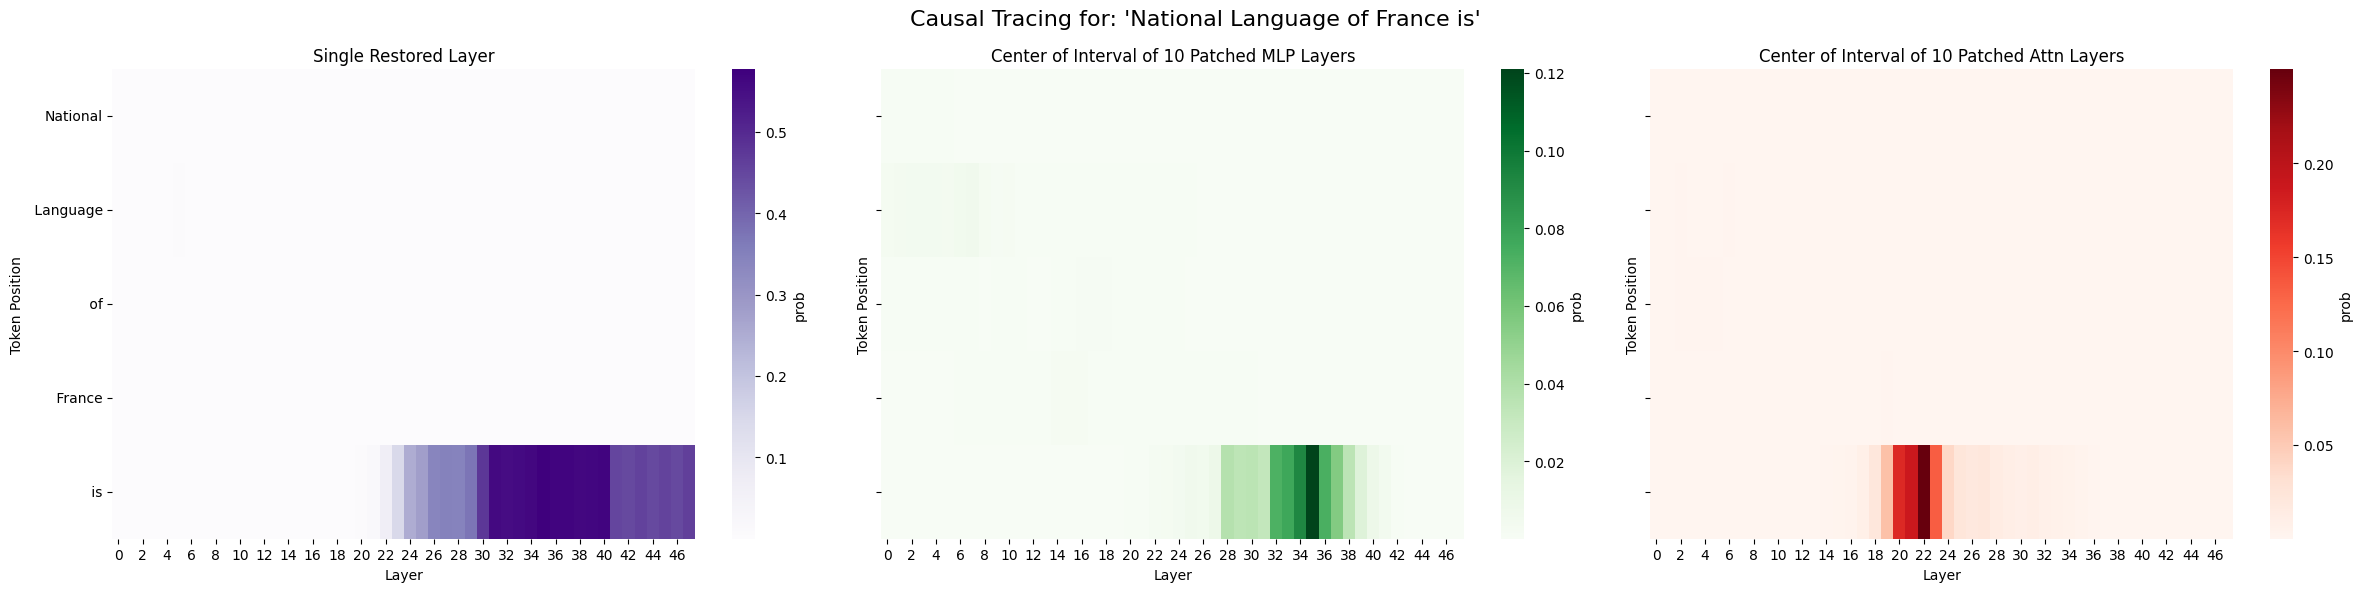

In [8]:
tokens_list1 = [t[1] for t in get_the_tokens_and_ids(tokenizer=tokenizer, base_text=ex1)]
plot_causal_tracing_side_by_side(
    pd.read_csv(f"outputs/gpt2-xl_{ex1}_causal_tracing_results.csv"),
    tokens=tokens_list1,
    title=f"Causal Tracing for: '{ex1}'"
)

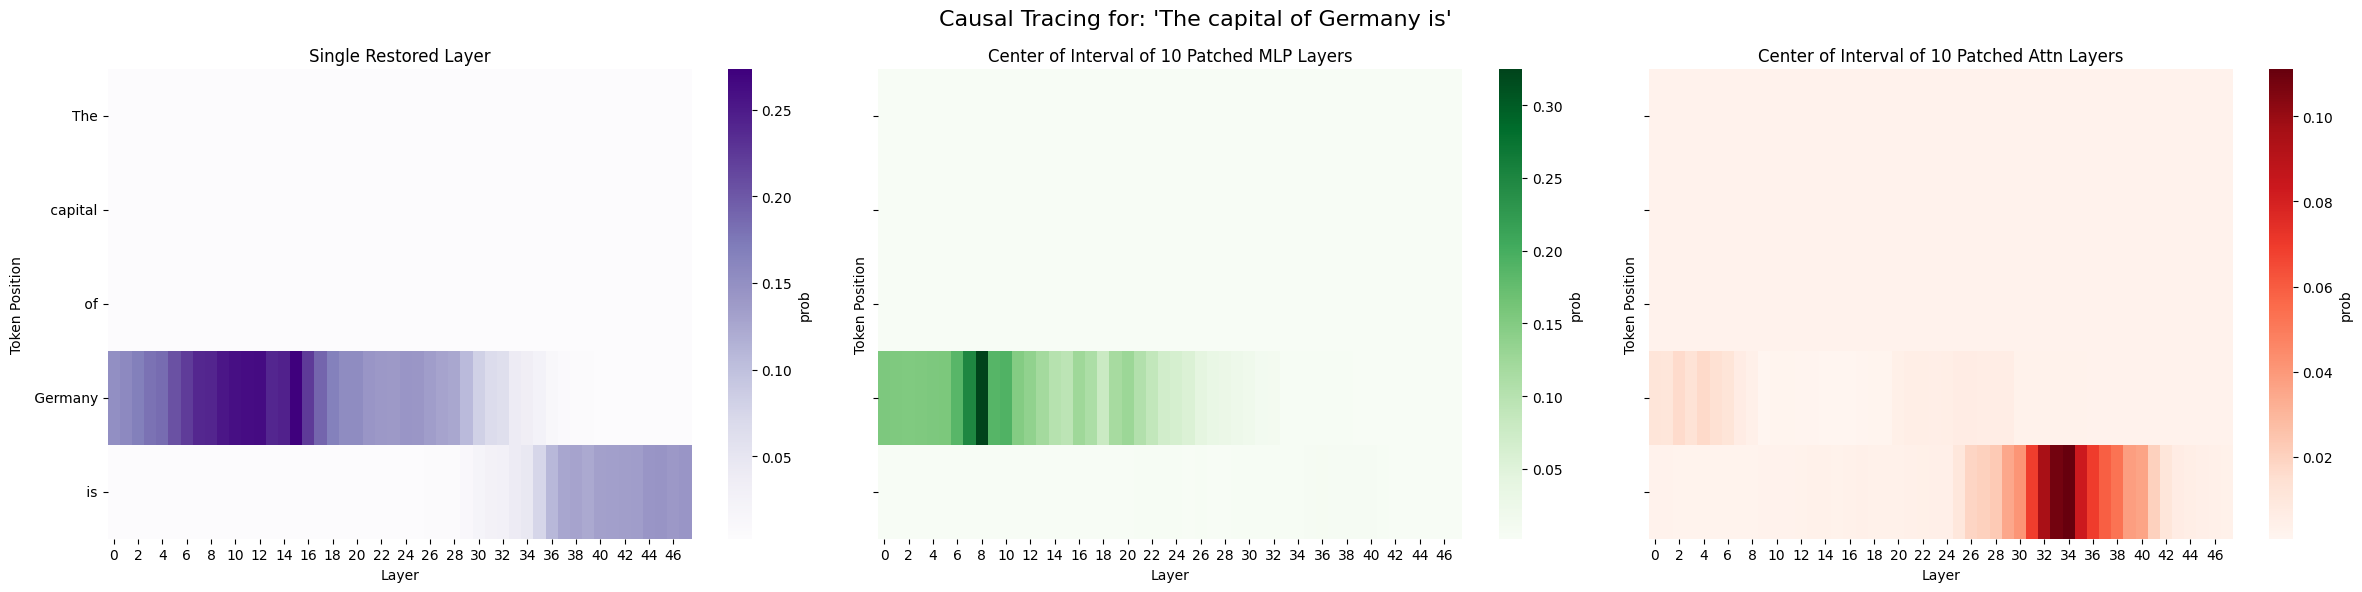

In [9]:
tokens_list2 = [t[1] for t in get_the_tokens_and_ids(tokenizer=tokenizer, base_text=ex2)]
plot_causal_tracing_side_by_side(
    pd.read_csv(f"outputs/gpt2-xl_{ex2}_causal_tracing_results.csv"),
    tokens=tokens_list2,
    title=f"Causal Tracing for: '{ex2}'"
)

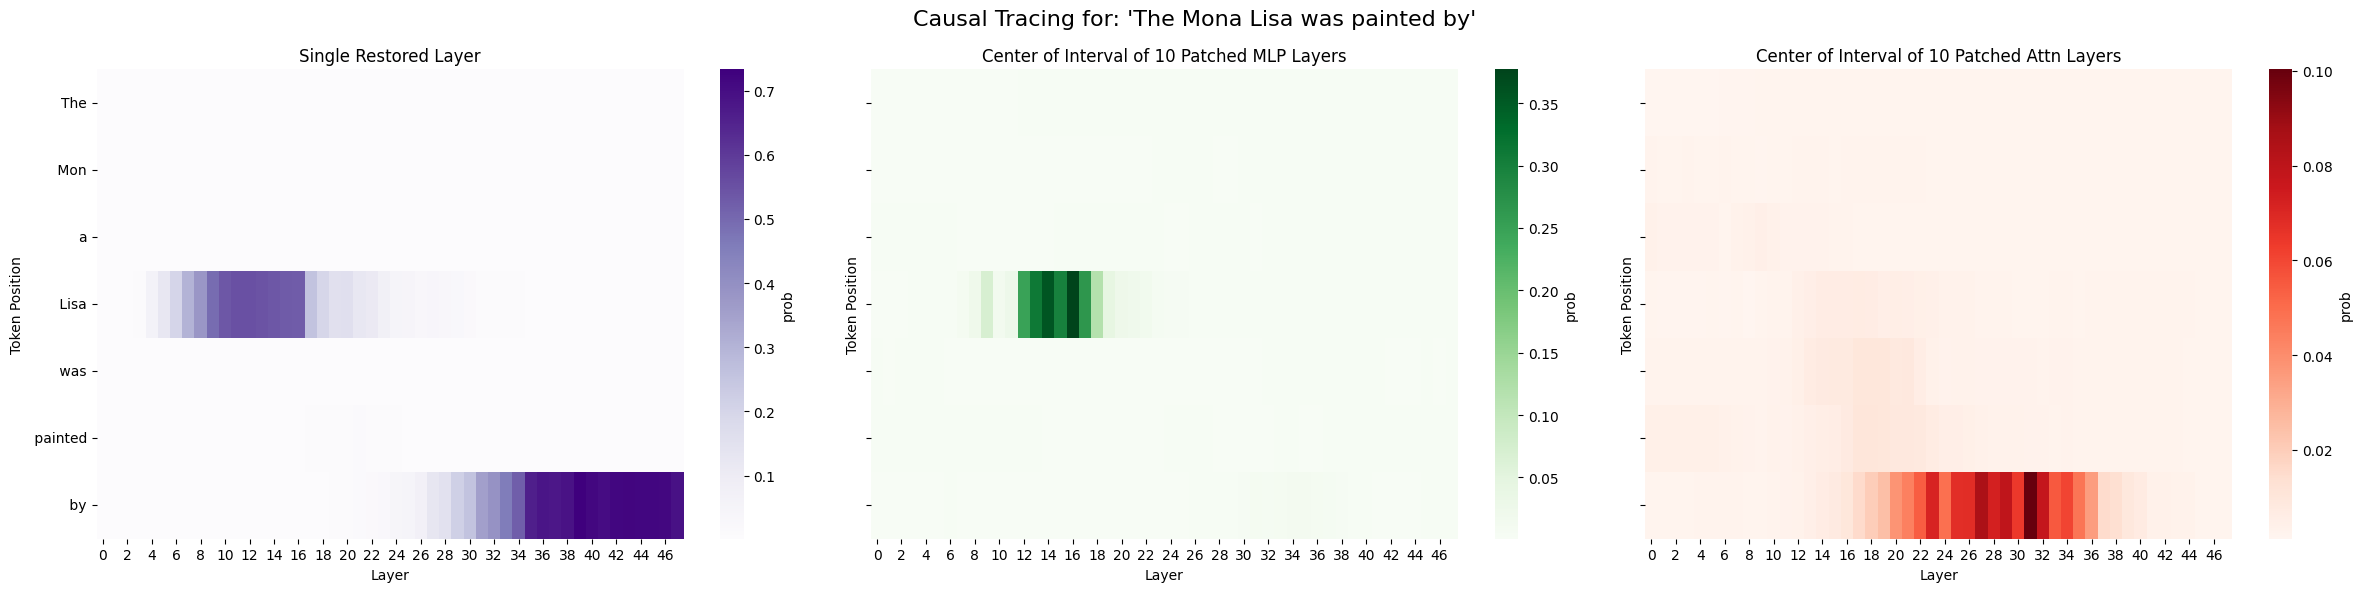

In [11]:
tokens_list3 = [t[1] for t in get_the_tokens_and_ids(tokenizer=tokenizer, base_text=ex3)]
plot_causal_tracing_side_by_side(
    pd.read_csv(f"outputs/gpt2-xl_{ex3}_causal_tracing_results.csv"),
    tokens=tokens_list3,
    title=f"Causal Tracing for: '{ex3}'"
)

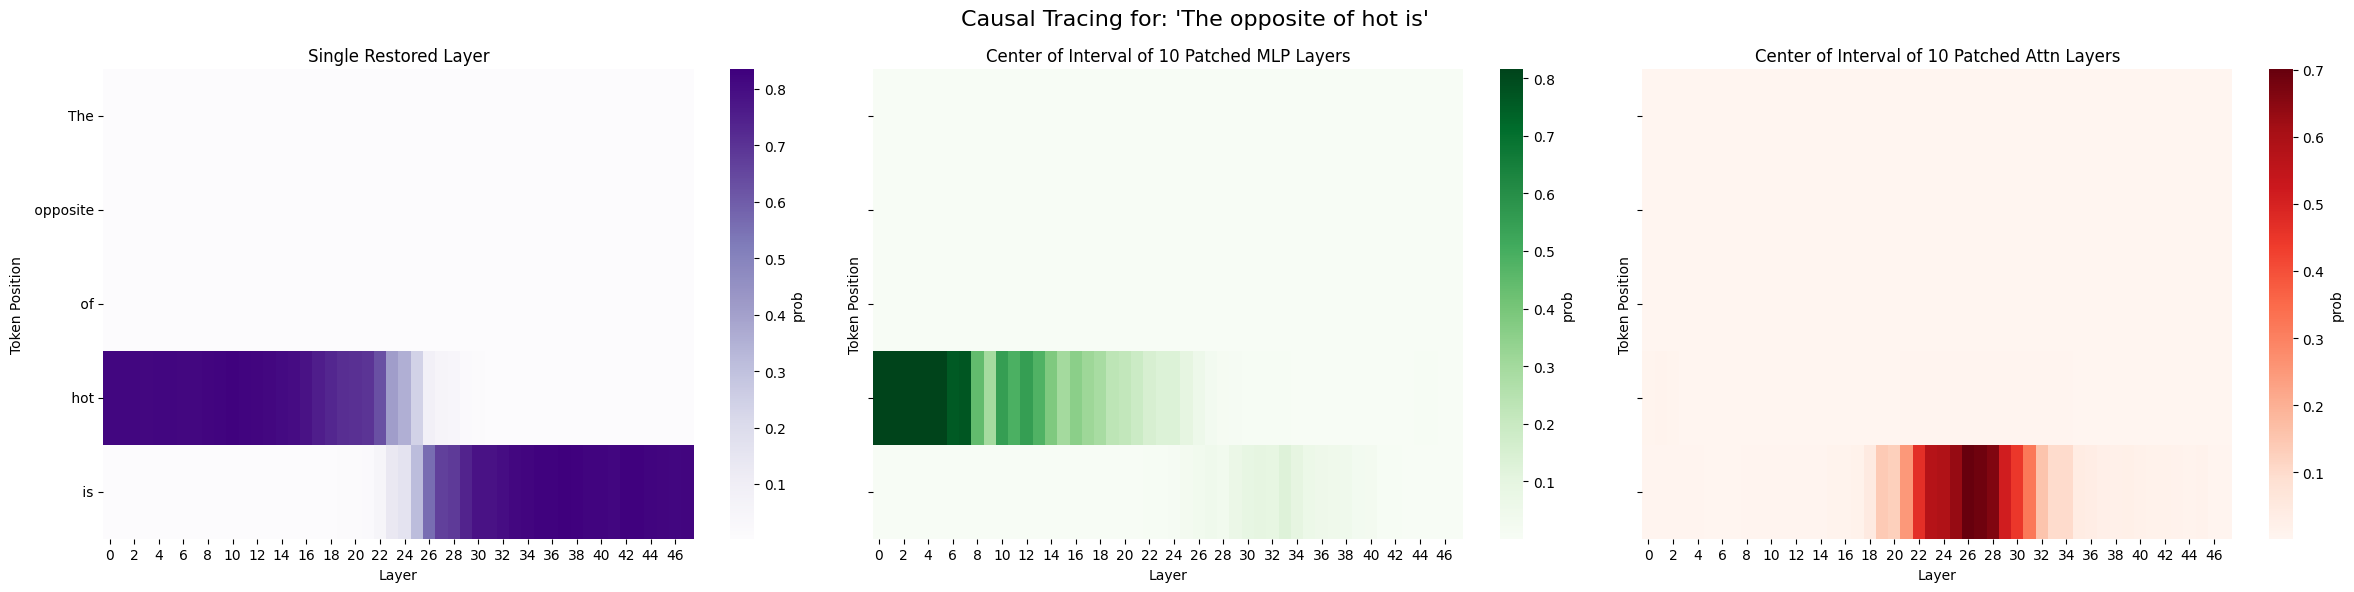

In [12]:
tokens_list4 = [t[1] for t in get_the_tokens_and_ids(tokenizer=tokenizer, base_text=ex4)]
plot_causal_tracing_side_by_side(
    pd.read_csv(f"outputs/gpt2-xl_{ex4}_causal_tracing_results.csv"),
    tokens=tokens_list4,
    title=f"Causal Tracing for: '{ex4}'"
)

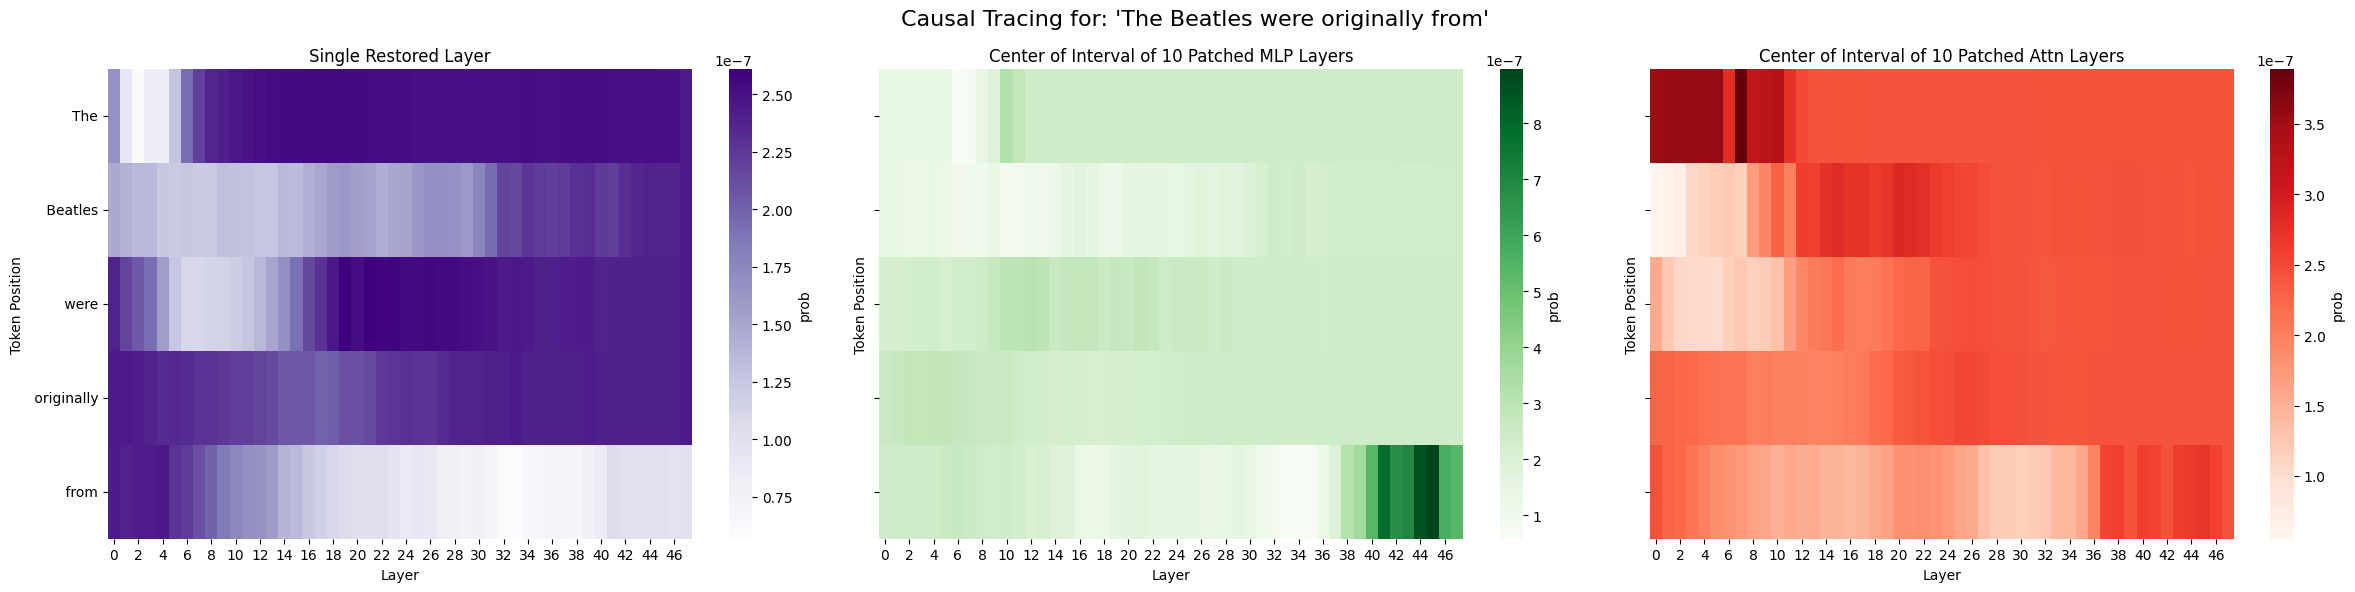

In [13]:
tokens_list_5 = [t[1] for t in get_the_tokens_and_ids(tokenizer=tokenizer, base_text=ex5)]
plot_causal_tracing_side_by_side(
    pd.read_csv(f"outputs/gpt2-xl_{ex5}_causal_tracing_results.csv"),
    tokens=tokens_list_5,
    title=f"Causal Tracing for: '{ex5}'"
)

# Zadanie 3

In [ ]:
def run_causal_tracing_yes_no(example_prompt, answer, subject_token_indices, model, tokenizer, model_name="gpt2-xl"):
    """
    Performs Causal Tracing (ROME) to locate where facts are stored in the model.

    Args:
        example_prompt (str): The prompt text (e.g., "The Space Needle is in downtown").
        subject_token_indices (list[int]): The indices of the subject tokens to corrupt (e.g., [0, 1, 2, 3]).
        model: The PyTorch model (e.g., GPT2-XL).
        tokenizer: The tokenizer associated with the model.

    Returns:
        pd.DataFrame: A dataframe containing 'layer', 'pos', 'prob', and 'stream' data.
    """
    if os.path.exists(f"outputs/yes_no_{model_name}_{example_prompt}_causal_tracing_results.csv"):
        print("Output file already exists. Skipping computation.")
        return pd.read_csv(f"outputs/yes_no_{model_name}_{example_prompt}_causal_tracing_results.csv")

    inputs = tokenizer(example_prompt, return_tensors="pt").to(device)

    yes_token_id = tokenizer.encode(" Yes")[0]
    no_token_id = tokenizer.encode(" No")[0]
    

    print(example_prompt)
    print("Expected answer:", answer)
    results = model(**inputs)
    distribiution_results = embed_to_distrib(
        model, results.last_hidden_state, logits=False
    )
    p_yes_clean = distribiution_results[0][-1][yes_token_id].detach().cpu().item()
    p_no_clean = distribiution_results[0][-1][no_token_id].detach().cpu().item()
    print(f"Clean run - P(Yes): {p_yes_clean}, P(No): {p_no_clean}")


    config_corrupted = corrupted_config(type(model))
    intervenable_corrupted = IntervenableModel(config_corrupted, model)
    _, corrupted_outputs = intervenable_corrupted(
        inputs, unit_locations={"base": ([[subject_token_indices]])}
    )
    distrib_corrupted = embed_to_distrib(
        model, corrupted_outputs.last_hidden_state, logits=False
    )
    p_yes_corrupted = distrib_corrupted[0][-1][yes_token_id].detach().cpu().item()
    p_no_corrupted = distrib_corrupted[0][-1][no_token_id].detach().cpu().item()
    print(f"Corrupted run - P(Yes): {p_yes_corrupted}, P(No): {p_no_corrupted}")


    num_layers = model.config.n_layer
    seq_len = inputs["input_ids"].shape[1]
    results = []

    streams = ["block_output", "mlp_activation", "attention_output"]


    print("Starting Causal Tracing scan...")
    for stream in streams:
        window = 1 if stream == "block_output" else 10

        for layer_i in tqdm(range(num_layers), desc=f"Scanning {stream}"):

            config = restore_corrupted_with_interval_config(
                layer=layer_i, stream=stream, window=window, num_layers=num_layers
            )

            n_restores = len(config.representations) - 1
            intervenable = IntervenableModel(config, model)


            for pos_i in range(seq_len):
                source_inputs = [None] + [inputs] * n_restores

                unit_locations = {
                    "sources->base": (
                        [None]
                        + [[[pos_i]]]
                        * n_restores,
                        [[subject_token_indices]]
                        + [[[pos_i]]] * n_restores,
                    )
                }

                _, counterfactual_outputs = intervenable(
                    inputs, source_inputs, unit_locations
                )
                

                distrib = embed_to_distrib(
                    model, counterfactual_outputs.last_hidden_state, logits=False
                )
                prob_yes = distrib[0][-1][yes_token_id].detach().cpu().item()
                prob_no = distrib[0][-1][no_token_id].detach().cpu().item()
                diff = prob_yes - p_yes_corrupted
                results.append(
                    {
                        "layer": layer_i,
                        "pos": pos_i,
                        "prob_yes": prob_yes,
                        "prob_no": prob_no,
                        "diff": diff,
                        "stream": stream,
                    }
                )
    results = pd.DataFrame(results)
    results.to_csv(f"outputs/yes_no_{model_name}_{example_prompt}_causal_tracing_results.csv", index=False)
    print("Causal Tracing scan completed.")
    return results

In [16]:
dataset=load_dataset("google/boolq", split="validation")

README.md: 0.00B [00:00, ?B/s]

c:\Users\jakub\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jakub\.cache\huggingface\hub\datasets--google--boolq. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For 

train-00000-of-00001.parquet:   0%|          | 0.00/3.69M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


validation-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3270 [00:00<?, ? examples/s]

In [ ]:
filtered_dataset = dataset.filter(lambda example: len(example['passage'].split()) < 13)
filtered_dataset

Filter:   0%|          | 0/3270 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'answer', 'passage'],
    num_rows: 9
})

In [18]:
selected_examples=[0,1,2,3,4,5,6,7]
examples = [filtered_dataset[i] for i in selected_examples]

In [19]:
examples

[{'question': 'was there helicopters in the second world war',
  'answer': True,
  'passage': 'Autogyros and helicopters were used during World War II. List includes prototypes.'},
 {'question': 'is peroxide and hydrogen peroxide the same thing',
  'answer': False,
  'passage': 'Aside from hydrogen peroxide, some other major classes of peroxides are these:'},
 {'question': 'is there such thing as a moon flower',
  'answer': True,
  'passage': 'A common name for several night-blooming plants, some with white flowers, including:'},
 {'question': 'can you score direct from a kickoff in football',
  'answer': True,
  'passage': 'A goal may be scored directly from a kick-off against the opponent.'},
 {'question': 'is a place to call home finished for good',
  'answer': False,
  'passage': 'The sixth and final season premiered on 19 August 2018.'},
 {'question': 'will there be a season 2 of penny on mars',
  'answer': True,
  'passage': 'On April 10, 2018, the production of the second season

In [20]:
prompts = [ex["passage"] + "\nQuestion: " + ex["question"] + "?" + "\nAnswer:" for ex in examples]
answers = [ex["answer"] for ex in examples]

In [21]:
ex1_yes_no_tokens = get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[0])
print(ex1_yes_no_tokens)
res1_ex1_gpt2_xl=run_causal_tracing_yes_no(
    example_prompt=prompts[0],
    answer=answers[0],
    subject_token_indices=[21],
    model=gpt,
    tokenizer=tokenizer,
    model_name="gpt2-xl"
)
res1_ex1_gpt2_xl_boolq = run_causal_tracing_yes_no(
    example_prompt=prompts[0],
    answer=answers[0],
    subject_token_indices=[21],
    model=gpt2,
    tokenizer=tokenizer2,
    model_name="boolq_gpt2-xl"
)

[(0, 'Aut', 16541), (1, 'ogy', 9868), (2, 'ros', 4951), (3, ' and', 290), (4, ' helicopters', 23890), (5, ' were', 547), (6, ' used', 973), (7, ' during', 1141), (8, ' World', 2159), (9, ' War', 1810), (10, ' II', 2873), (11, '.', 13), (12, ' List', 7343), (13, ' includes', 3407), (14, ' prototypes', 32338), (15, '.', 13), (16, '\n', 198), (17, 'Question', 24361), (18, ':', 25), (19, ' was', 373), (20, ' there', 612), (21, ' helicopters', 23890), (22, ' in', 287), (23, ' the', 262), (24, ' second', 1218), (25, ' world', 995), (26, ' war', 1175), (27, '?', 30), (28, '\n', 198), (29, 'Answer', 33706), (30, ':', 25)]
Output file already exists. Skipping computation.
Output file already exists. Skipping computation.


In [22]:
ex2_yes_no_tokens = get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[1])
print(ex2_yes_no_tokens)
res2_ex2_gpt2_xl = run_causal_tracing_yes_no(
    example_prompt=prompts[1],
    answer=answers[1],
    subject_token_indices=[21,22,24,25,26],
    model=gpt,
    tokenizer=tokenizer
)
res2_ex2_gpt2_xl_boolq = run_causal_tracing_yes_no(
    example_prompt=prompts[1],
    answer=answers[1],
    subject_token_indices=[21,22,24,25,26],
    model=gpt2,
    tokenizer=tokenizer2,
    model_name="boolq_gpt2-xl"
)

[(0, 'Aside', 32602), (1, ' from', 422), (2, ' hydrogen', 17669), (3, ' per', 583), (4, 'oxide', 28885), (5, ',', 11), (6, ' some', 617), (7, ' other', 584), (8, ' major', 1688), (9, ' classes', 6097), (10, ' of', 286), (11, ' per', 583), (12, 'ox', 1140), (13, 'ides', 1460), (14, ' are', 389), (15, ' these', 777), (16, ':', 25), (17, '\n', 198), (18, 'Question', 24361), (19, ':', 25), (20, ' is', 318), (21, ' per', 583), (22, 'oxide', 28885), (23, ' and', 290), (24, ' hydrogen', 17669), (25, ' per', 583), (26, 'oxide', 28885), (27, ' the', 262), (28, ' same', 976), (29, ' thing', 1517), (30, '?', 30), (31, '\n', 198), (32, 'Answer', 33706), (33, ':', 25)]


Output file already exists. Skipping computation.
Output file already exists. Skipping computation.


In [23]:
ex3_yes_no_tokens = get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[2])
print(ex3_yes_no_tokens)
res3_ex3_gpt2_xl = run_causal_tracing_yes_no(
    example_prompt=prompts[2],
    answer=answers[2],
    subject_token_indices=[26,27,28],
    model=gpt,
    tokenizer=tokenizer,
    model_name="gpt2-xl",
)
res3_ex3_gpt2_xl_boolq = run_causal_tracing_yes_no(
    example_prompt=prompts[2],
    answer=answers[2],
    subject_token_indices=[26, 27, 28],
    model=gpt2,
    tokenizer=tokenizer2,
    model_name="boolq_gpt2-xl",
)

[(0, 'A', 32), (1, ' common', 2219), (2, ' name', 1438), (3, ' for', 329), (4, ' several', 1811), (5, ' night', 1755), (6, '-', 12), (7, 'bl', 2436), (8, 'ooming', 30602), (9, ' plants', 6134), (10, ',', 11), (11, ' some', 617), (12, ' with', 351), (13, ' white', 2330), (14, ' flowers', 12734), (15, ',', 11), (16, ' including', 1390), (17, ':', 25), (18, '\n', 198), (19, 'Question', 24361), (20, ':', 25), (21, ' is', 318), (22, ' there', 612), (23, ' such', 884), (24, ' thing', 1517), (25, ' as', 355), (26, ' a', 257), (27, ' moon', 8824), (28, ' flower', 15061), (29, '?', 30), (30, '\n', 198), (31, 'Answer', 33706), (32, ':', 25)]


Output file already exists. Skipping computation.


Output file already exists. Skipping computation.


In [24]:
ex4_yes_no_tokens = get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[3])
print(ex4_yes_no_tokens)
res4_ex4_gpt2_xl = run_causal_tracing_yes_no(
    example_prompt=prompts[3],
    answer=answers[3],
    subject_token_indices=[23,24],
    model=gpt,
    tokenizer=tokenizer
)
res4_ex4_gpt2_xl_boolq = run_causal_tracing_yes_no(
    example_prompt=prompts[3],
    answer=answers[3],
    subject_token_indices=[23,24],
    model=gpt2,
    tokenizer=tokenizer2,
    model_name="boolq_gpt2-xl",
)

[(0, 'A', 32), (1, ' goal', 3061), (2, ' may', 743), (3, ' be', 307), (4, ' scored', 7781), (5, ' directly', 3264), (6, ' from', 422), (7, ' a', 257), (8, ' kick', 4829), (9, '-', 12), (10, 'off', 2364), (11, ' against', 1028), (12, ' the', 262), (13, ' opponent', 6125), (14, '.', 13), (15, '\n', 198), (16, 'Question', 24361), (17, ':', 25), (18, ' can', 460), (19, ' you', 345), (20, ' score', 4776), (21, ' direct', 1277), (22, ' from', 422), (23, ' a', 257), (24, ' kickoff', 40532), (25, ' in', 287), (26, ' football', 4346), (27, '?', 30), (28, '\n', 198), (29, 'Answer', 33706), (30, ':', 25)]


Output file already exists. Skipping computation.
Output file already exists. Skipping computation.


In [25]:
ex5_yes_no_tokens = get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[4])
print(ex5_yes_no_tokens)
res5_ex5_gpt2_xl = run_causal_tracing_yes_no(
    example_prompt=prompts[4],
    answer=answers[4],
    subject_token_indices=[15,16,17,18,19],
    model=gpt,
    tokenizer=tokenizer
)
res5_ex5_gpt2_xl_boolq = run_causal_tracing_yes_no(
    example_prompt=prompts[4],
    answer=answers[4],
    subject_token_indices=[15,16,17,18,19],
    model=gpt2,
    tokenizer=tokenizer2,
    model_name="boolq_gpt2-xl",
)

[(0, 'The', 464), (1, ' sixth', 11695), (2, ' and', 290), (3, ' final', 2457), (4, ' season', 1622), (5, ' premiered', 44119), (6, ' on', 319), (7, ' 19', 678), (8, ' August', 2932), (9, ' 2018', 2864), (10, '.', 13), (11, '\n', 198), (12, 'Question', 24361), (13, ':', 25), (14, ' is', 318), (15, ' a', 257), (16, ' place', 1295), (17, ' to', 284), (18, ' call', 869), (19, ' home', 1363), (20, ' finished', 5201), (21, ' for', 329), (22, ' good', 922), (23, '?', 30), (24, '\n', 198), (25, 'Answer', 33706), (26, ':', 25)]


Output file already exists. Skipping computation.


Output file already exists. Skipping computation.


In [26]:
ex6_yes_no_tokens = get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[5])
print(ex6_yes_no_tokens)
res6_ex6_gpt2_xl = run_causal_tracing_yes_no(
    example_prompt=prompts[5],
    answer=answers[5],
    subject_token_indices=[21,22,23],
    model=gpt,
    tokenizer=tokenizer
)
res6_ex6_gpt2_xl_boolq = run_causal_tracing_yes_no(
    example_prompt=prompts[5],
    answer=answers[5],
    subject_token_indices=[21,22,23],
    model=gpt2,
    tokenizer=tokenizer2,
    model_name="boolq_gpt2-xl",
)

[(0, 'On', 2202), (1, ' April', 3035), (2, ' 10', 838), (3, ',', 11), (4, ' 2018', 2864), (5, ',', 11), (6, ' the', 262), (7, ' production', 3227), (8, ' of', 286), (9, ' the', 262), (10, ' second', 1218), (11, ' season', 1622), (12, ' was', 373), (13, ' announced', 3414), (14, '.', 13), (15, '\n', 198), (16, 'Question', 24361), (17, ':', 25), (18, ' will', 481), (19, ' there', 612), (20, ' be', 307), (21, ' a', 257), (22, ' season', 1622), (23, ' 2', 362), (24, ' of', 286), (25, ' penny', 26369), (26, ' on', 319), (27, ' mars', 48962), (28, '?', 30), (29, '\n', 198), (30, 'Answer', 33706), (31, ':', 25)]


Output file already exists. Skipping computation.
On April 10, 2018, the production of the second season was announced.
Question: will there be a season 2 of penny on mars?
Answer:
Expected answer: True


Clean run - P(Yes): 0.13796913623809814, P(No): 0.003115604165941477
Corrupted run - P(Yes): 0.12558871507644653, P(No): 0.004912311676889658
Starting Causal Tracing scan...



Scanning block_output:   0%|          | 0/48 [00:00<?, ?it/s]


Scanning block_output:   2%|▏         | 1/48 [00:02<01:57,  2.51s/it]


Scanning block_output:   4%|▍         | 2/48 [00:04<01:54,  2.49s/it]


Scanning block_output:   6%|▋         | 3/48 [00:07<01:51,  2.48s/it]


Scanning block_output:   8%|▊         | 4/48 [00:09<01:49,  2.48s/it]


Scanning block_output:  10%|█         | 5/48 [00:12<01:49,  2.54s/it]


Scanning block_output:  12%|█▎        | 6/48 [00:15<01:45,  2.52s/it]


Scanning block_output:  15%|█▍        | 7/48 [00:17<01:42,  2.50s/it]


Scanning block_output:  17%|█▋        | 8/48 [00:20<01:39,  2.49s/it]


Scanning block_output:  19%|█▉        | 9/48 [00:22<01:37,  2.49s/it]


Scanning block_output:  21%|██        | 10/48 [00:24<01:34,  2.48s/it]


Scanning block_output:  23%|██▎       | 11/48 [00:27<01:31,  2.48s/it]


Scanning block_output:  25%|██▌       | 12/48 [00:29<01:29,  2.48s/it]


Scanning block_output:  27%|██▋       | 13/48 [00:32<01:26,  2.48s/it]


Scanning block_output:  29%|██▉       | 14/48 [00:34<01:24,  2.48s/it]


Scanning block_output:  31%|███▏      | 15/48 [00:37<01:21,  2.48s/it]


Scanning block_output:  33%|███▎      | 16/48 [00:39<01:19,  2.48s/it]


Scanning block_output:  35%|███▌      | 17/48 [00:42<01:16,  2.48s/it]


Scanning block_output:  38%|███▊      | 18/48 [00:44<01:14,  2.48s/it]


Scanning block_output:  40%|███▉      | 19/48 [00:47<01:11,  2.48s/it]


Scanning block_output:  42%|████▏     | 20/48 [00:49<01:09,  2.48s/it]


Scanning block_output:  44%|████▍     | 21/48 [00:52<01:06,  2.48s/it]


Scanning block_output:  46%|████▌     | 22/48 [00:54<01:04,  2.48s/it]


Scanning block_output:  48%|████▊     | 23/48 [00:57<01:01,  2.48s/it]


Scanning block_output:  50%|█████     | 24/48 [00:59<00:59,  2.48s/it]


Scanning block_output:  52%|█████▏    | 25/48 [01:02<00:56,  2.48s/it]


Scanning block_output:  54%|█████▍    | 26/48 [01:04<00:54,  2.48s/it]


Scanning block_output:  56%|█████▋    | 27/48 [01:07<00:52,  2.48s/it]


Scanning block_output:  58%|█████▊    | 28/48 [01:09<00:49,  2.48s/it]


Scanning block_output:  60%|██████    | 29/48 [01:12<00:47,  2.48s/it]


Scanning block_output:  62%|██████▎   | 30/48 [01:14<00:44,  2.48s/it]


Scanning block_output:  65%|██████▍   | 31/48 [01:16<00:42,  2.48s/it]


Scanning block_output:  67%|██████▋   | 32/48 [01:19<00:39,  2.48s/it]


Scanning block_output:  69%|██████▉   | 33/48 [01:21<00:37,  2.48s/it]


Scanning block_output:  71%|███████   | 34/48 [01:24<00:34,  2.48s/it]


Scanning block_output:  73%|███████▎  | 35/48 [01:26<00:32,  2.48s/it]


Scanning block_output:  75%|███████▌  | 36/48 [01:29<00:29,  2.48s/it]


Scanning block_output:  77%|███████▋  | 37/48 [01:31<00:27,  2.48s/it]


Scanning block_output:  79%|███████▉  | 38/48 [01:34<00:24,  2.48s/it]


Scanning block_output:  81%|████████▏ | 39/48 [01:36<00:22,  2.48s/it]


Scanning block_output:  83%|████████▎ | 40/48 [01:39<00:19,  2.48s/it]


Scanning block_output:  85%|████████▌ | 41/48 [01:41<00:17,  2.48s/it]


Scanning block_output:  88%|████████▊ | 42/48 [01:44<00:14,  2.48s/it]


Scanning block_output:  90%|████████▉ | 43/48 [01:46<00:12,  2.48s/it]


Scanning block_output:  92%|█████████▏| 44/48 [01:49<00:09,  2.48s/it]


Scanning block_output:  94%|█████████▍| 45/48 [01:51<00:07,  2.48s/it]


Scanning block_output:  96%|█████████▌| 46/48 [01:54<00:04,  2.48s/it]


Scanning block_output:  98%|█████████▊| 47/48 [01:56<00:02,  2.48s/it]


Scanning block_output: 100%|██████████| 48/48 [01:59<00:00,  2.48s/it]


Scanning block_output: 100%|██████████| 48/48 [01:59<00:00,  2.48s/it]


Scanning mlp_activation:   0%|          | 0/48 [00:00<?, ?it/s]


Scanning mlp_activation:   2%|▏         | 1/48 [00:07<05:41,  7.26s/it]


Scanning mlp_activation:   4%|▍         | 2/48 [00:15<06:06,  7.96s/it]


Scanning mlp_activation:   6%|▋         | 3/48 [00:25<06:32,  8.73s/it]


Scanning mlp_activation:   8%|▊         | 4/48 [00:36<07:00,  9.56s/it]


Scanning mlp_activation:  10%|█         | 5/48 [00:48<07:31, 10.50s/it]


Scanning mlp_activation:  12%|█▎        | 6/48 [01:01<08:00, 11.43s/it]


Scanning mlp_activation:  15%|█▍        | 7/48 [01:14<08:12, 12.02s/it]


Scanning mlp_activation:  17%|█▋        | 8/48 [01:28<08:16, 12.40s/it]


Scanning mlp_activation:  19%|█▉        | 9/48 [01:41<08:13, 12.66s/it]


Scanning mlp_activation:  21%|██        | 10/48 [01:54<08:07, 12.84s/it]


Scanning mlp_activation:  23%|██▎       | 11/48 [02:07<07:59, 12.96s/it]


Scanning mlp_activation:  25%|██▌       | 12/48 [02:20<07:49, 13.03s/it]


Scanning mlp_activation:  27%|██▋       | 13/48 [02:34<07:37, 13.08s/it]


Scanning mlp_activation:  29%|██▉       | 14/48 [02:47<07:27, 13.17s/it]


Scanning mlp_activation:  31%|███▏      | 15/48 [03:00<07:13, 13.15s/it]


Scanning mlp_activation:  33%|███▎      | 16/48 [03:13<07:01, 13.16s/it]


Scanning mlp_activation:  35%|███▌      | 17/48 [03:26<06:48, 13.17s/it]


Scanning mlp_activation:  38%|███▊      | 18/48 [03:40<06:35, 13.17s/it]


Scanning mlp_activation:  40%|███▉      | 19/48 [03:53<06:21, 13.17s/it]


Scanning mlp_activation:  42%|████▏     | 20/48 [04:06<06:08, 13.18s/it]


Scanning mlp_activation:  44%|████▍     | 21/48 [04:19<05:56, 13.19s/it]


Scanning mlp_activation:  46%|████▌     | 22/48 [04:32<05:43, 13.19s/it]


Scanning mlp_activation:  48%|████▊     | 23/48 [04:46<05:29, 13.20s/it]


Scanning mlp_activation:  50%|█████     | 24/48 [04:59<05:17, 13.25s/it]


Scanning mlp_activation:  52%|█████▏    | 25/48 [05:12<05:04, 13.24s/it]


Scanning mlp_activation:  54%|█████▍    | 26/48 [05:25<04:51, 13.24s/it]


Scanning mlp_activation:  56%|█████▋    | 27/48 [05:39<04:37, 13.24s/it]


Scanning mlp_activation:  58%|█████▊    | 28/48 [05:52<04:24, 13.24s/it]


Scanning mlp_activation:  60%|██████    | 29/48 [06:05<04:11, 13.24s/it]


Scanning mlp_activation:  62%|██████▎   | 30/48 [06:18<03:58, 13.25s/it]


Scanning mlp_activation:  65%|██████▍   | 31/48 [06:32<03:45, 13.25s/it]


Scanning mlp_activation:  67%|██████▋   | 32/48 [06:45<03:32, 13.27s/it]


Scanning mlp_activation:  69%|██████▉   | 33/48 [06:58<03:19, 13.31s/it]


Scanning mlp_activation:  71%|███████   | 34/48 [07:12<03:06, 13.30s/it]


Scanning mlp_activation:  73%|███████▎  | 35/48 [07:25<02:52, 13.29s/it]


Scanning mlp_activation:  75%|███████▌  | 36/48 [07:38<02:39, 13.29s/it]


Scanning mlp_activation:  77%|███████▋  | 37/48 [07:52<02:26, 13.28s/it]


Scanning mlp_activation:  79%|███████▉  | 38/48 [08:05<02:12, 13.28s/it]


Scanning mlp_activation:  81%|████████▏ | 39/48 [08:18<01:59, 13.27s/it]


Scanning mlp_activation:  83%|████████▎ | 40/48 [08:31<01:45, 13.25s/it]


Scanning mlp_activation:  85%|████████▌ | 41/48 [08:44<01:32, 13.24s/it]


Scanning mlp_activation:  88%|████████▊ | 42/48 [08:58<01:19, 13.24s/it]


Scanning mlp_activation:  90%|████████▉ | 43/48 [09:11<01:06, 13.29s/it]


Scanning mlp_activation:  92%|█████████▏| 44/48 [09:24<00:53, 13.28s/it]


Scanning mlp_activation:  94%|█████████▍| 45/48 [09:36<00:38, 12.92s/it]


Scanning mlp_activation:  96%|█████████▌| 46/48 [09:47<00:24, 12.31s/it]


Scanning mlp_activation:  98%|█████████▊| 47/48 [09:57<00:11, 11.52s/it]


Scanning mlp_activation: 100%|██████████| 48/48 [10:05<00:00, 10.61s/it]


Scanning mlp_activation: 100%|██████████| 48/48 [10:05<00:00, 12.62s/it]


Scanning attention_output:   0%|          | 0/48 [00:00<?, ?it/s]


Scanning attention_output:   2%|▏         | 1/48 [00:07<05:42,  7.28s/it]


Scanning attention_output:   4%|▍         | 2/48 [00:15<06:07,  7.99s/it]


Scanning attention_output:   6%|▋         | 3/48 [00:25<06:34,  8.76s/it]


Scanning attention_output:   8%|▊         | 4/48 [00:36<07:02,  9.59s/it]


Scanning attention_output:  10%|█         | 5/48 [00:48<07:30, 10.49s/it]


Scanning attention_output:  12%|█▎        | 6/48 [01:01<08:02, 11.48s/it]


Scanning attention_output:  15%|█▍        | 7/48 [01:15<08:14, 12.06s/it]


Scanning attention_output:  17%|█▋        | 8/48 [01:28<08:17, 12.44s/it]


Scanning attention_output:  19%|█▉        | 9/48 [01:41<08:15, 12.71s/it]


Scanning attention_output:  21%|██        | 10/48 [01:54<08:10, 12.90s/it]


Scanning attention_output:  23%|██▎       | 11/48 [02:08<08:02, 13.03s/it]


Scanning attention_output:  25%|██▌       | 12/48 [02:21<07:52, 13.12s/it]


Scanning attention_output:  27%|██▋       | 13/48 [02:34<07:41, 13.19s/it]


Scanning attention_output:  29%|██▉       | 14/48 [02:48<07:29, 13.23s/it]


Scanning attention_output:  31%|███▏      | 15/48 [03:01<07:17, 13.26s/it]


Scanning attention_output:  33%|███▎      | 16/48 [03:15<07:06, 13.31s/it]


Scanning attention_output:  35%|███▌      | 17/48 [03:28<06:52, 13.31s/it]


Scanning attention_output:  38%|███▊      | 18/48 [03:41<06:39, 13.31s/it]


Scanning attention_output:  40%|███▉      | 19/48 [03:54<06:25, 13.29s/it]


Scanning attention_output:  42%|████▏     | 20/48 [04:08<06:12, 13.29s/it]


Scanning attention_output:  44%|████▍     | 21/48 [04:21<05:58, 13.29s/it]


Scanning attention_output:  46%|████▌     | 22/48 [04:34<05:45, 13.28s/it]


Scanning attention_output:  48%|████▊     | 23/48 [04:48<05:32, 13.29s/it]


Scanning attention_output:  50%|█████     | 24/48 [05:01<05:19, 13.29s/it]


Scanning attention_output:  52%|█████▏    | 25/48 [05:14<05:06, 13.34s/it]


Scanning attention_output:  54%|█████▍    | 26/48 [05:28<04:53, 13.32s/it]


Scanning attention_output:  56%|█████▋    | 27/48 [05:41<04:39, 13.32s/it]


Scanning attention_output:  58%|█████▊    | 28/48 [05:54<04:26, 13.31s/it]


Scanning attention_output:  60%|██████    | 29/48 [06:07<04:12, 13.31s/it]


Scanning attention_output:  62%|██████▎   | 30/48 [06:21<03:59, 13.30s/it]


Scanning attention_output:  65%|██████▍   | 31/48 [06:34<03:46, 13.30s/it]


Scanning attention_output:  67%|██████▋   | 32/48 [06:47<03:32, 13.31s/it]


Scanning attention_output:  69%|██████▉   | 33/48 [07:01<03:19, 13.31s/it]


Scanning attention_output:  71%|███████   | 34/48 [07:14<03:06, 13.32s/it]


Scanning attention_output:  73%|███████▎  | 35/48 [07:28<02:53, 13.37s/it]


Scanning attention_output:  75%|███████▌  | 36/48 [07:41<02:40, 13.36s/it]


Scanning attention_output:  77%|███████▋  | 37/48 [07:54<02:26, 13.35s/it]


Scanning attention_output:  79%|███████▉  | 38/48 [08:07<02:13, 13.34s/it]


Scanning attention_output:  81%|████████▏ | 39/48 [08:21<02:00, 13.34s/it]


Scanning attention_output:  83%|████████▎ | 40/48 [08:34<01:46, 13.35s/it]


Scanning attention_output:  85%|████████▌ | 41/48 [08:48<01:33, 13.35s/it]


Scanning attention_output:  88%|████████▊ | 42/48 [09:01<01:20, 13.35s/it]


Scanning attention_output:  90%|████████▉ | 43/48 [09:14<01:06, 13.34s/it]


Scanning attention_output:  92%|█████████▏| 44/48 [09:28<00:53, 13.37s/it]


Scanning attention_output:  94%|█████████▍| 45/48 [09:40<00:38, 12.97s/it]


Scanning attention_output:  96%|█████████▌| 46/48 [09:50<00:24, 12.31s/it]


Scanning attention_output:  98%|█████████▊| 47/48 [10:00<00:11, 11.50s/it]


Scanning attention_output: 100%|██████████| 48/48 [10:08<00:00, 10.57s/it]


Scanning attention_output: 100%|██████████| 48/48 [10:08<00:00, 12.69s/it]

Causal Tracing scan completed.


In [27]:
ex7_yes_no_tokens = get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[6])
print(ex7_yes_no_tokens)
res7_ex7_gpt2_xl = run_causal_tracing_yes_no(
    example_prompt=prompts[6],
    answer=answers[6],
    subject_token_indices=[17,18,19,20,21],
    model=gpt,
    tokenizer=tokenizer
)
res7_ex7_gpt2_xl_boolq = run_causal_tracing_yes_no(
    example_prompt=prompts[6],
    answer=answers[6],
    subject_token_indices=[17,18,19,20,21],
    model=gpt2,
    tokenizer=tokenizer2,
    model_name="boolq_gpt2-xl",
)

[(0, 'The', 464), (1, ' season', 1622), (2, ' is', 318), (3, ' set', 900), (4, ' for', 329), (5, ' release', 2650), (6, ' in', 287), (7, ' 2019', 13130), (8, '.', 13), (9, '\n', 198), (10, 'Question', 24361), (11, ':', 25), (12, ' are', 389), (13, ' they', 484), (14, ' going', 1016), (15, ' to', 284), (16, ' make', 787), (17, ' a', 257), (18, ' pun', 4000), (19, 'isher', 4828), (20, ' season', 1622), (21, ' 2', 362), (22, '?', 30), (23, '\n', 198), (24, 'Answer', 33706), (25, ':', 25)]
The season is set for release in 2019.
Question: are they going to make a punisher season 2?
Answer:
Expected answer: True


Clean run - P(Yes): 0.03436429426074028, P(No): 0.03850643336772919
Corrupted run - P(Yes): 0.06210967153310776, P(No): 0.05112340673804283
Starting Causal Tracing scan...



Scanning block_output:   0%|          | 0/48 [00:00<?, ?it/s]


Scanning block_output:   2%|▏         | 1/48 [00:02<01:34,  2.01s/it]


Scanning block_output:   4%|▍         | 2/48 [00:04<01:32,  2.00s/it]


Scanning block_output:   6%|▋         | 3/48 [00:06<01:30,  2.00s/it]


Scanning block_output:   8%|▊         | 4/48 [00:08<01:28,  2.00s/it]


Scanning block_output:  10%|█         | 5/48 [00:10<01:26,  2.00s/it]


Scanning block_output:  12%|█▎        | 6/48 [00:12<01:24,  2.00s/it]


Scanning block_output:  15%|█▍        | 7/48 [00:14<01:22,  2.00s/it]


Scanning block_output:  17%|█▋        | 8/48 [00:16<01:20,  2.00s/it]


Scanning block_output:  19%|█▉        | 9/48 [00:18<01:18,  2.00s/it]


Scanning block_output:  21%|██        | 10/48 [00:20<01:16,  2.00s/it]


Scanning block_output:  23%|██▎       | 11/48 [00:22<01:14,  2.00s/it]


Scanning block_output:  25%|██▌       | 12/48 [00:24<01:12,  2.00s/it]


Scanning block_output:  27%|██▋       | 13/48 [00:26<01:10,  2.00s/it]


Scanning block_output:  29%|██▉       | 14/48 [00:28<01:08,  2.00s/it]


Scanning block_output:  31%|███▏      | 15/48 [00:30<01:06,  2.00s/it]


Scanning block_output:  33%|███▎      | 16/48 [00:32<01:04,  2.00s/it]


Scanning block_output:  35%|███▌      | 17/48 [00:34<01:02,  2.00s/it]


Scanning block_output:  38%|███▊      | 18/48 [00:36<01:00,  2.00s/it]


Scanning block_output:  40%|███▉      | 19/48 [00:38<00:58,  2.00s/it]


Scanning block_output:  42%|████▏     | 20/48 [00:40<00:56,  2.00s/it]


Scanning block_output:  44%|████▍     | 21/48 [00:42<00:54,  2.00s/it]


Scanning block_output:  46%|████▌     | 22/48 [00:44<00:52,  2.00s/it]


Scanning block_output:  48%|████▊     | 23/48 [00:46<00:50,  2.00s/it]


Scanning block_output:  50%|█████     | 24/48 [00:48<00:48,  2.00s/it]


Scanning block_output:  52%|█████▏    | 25/48 [00:50<00:46,  2.00s/it]


Scanning block_output:  54%|█████▍    | 26/48 [00:52<00:44,  2.00s/it]


Scanning block_output:  56%|█████▋    | 27/48 [00:54<00:42,  2.01s/it]


Scanning block_output:  58%|█████▊    | 28/48 [00:56<00:40,  2.00s/it]


Scanning block_output:  60%|██████    | 29/48 [00:58<00:38,  2.00s/it]


Scanning block_output:  62%|██████▎   | 30/48 [01:00<00:36,  2.00s/it]


Scanning block_output:  65%|██████▍   | 31/48 [01:02<00:34,  2.00s/it]


Scanning block_output:  67%|██████▋   | 32/48 [01:04<00:32,  2.00s/it]


Scanning block_output:  69%|██████▉   | 33/48 [01:06<00:30,  2.00s/it]


Scanning block_output:  71%|███████   | 34/48 [01:08<00:28,  2.00s/it]


Scanning block_output:  73%|███████▎  | 35/48 [01:10<00:26,  2.00s/it]


Scanning block_output:  75%|███████▌  | 36/48 [01:12<00:24,  2.00s/it]


Scanning block_output:  77%|███████▋  | 37/48 [01:14<00:22,  2.00s/it]


Scanning block_output:  79%|███████▉  | 38/48 [01:16<00:20,  2.00s/it]


Scanning block_output:  81%|████████▏ | 39/48 [01:18<00:18,  2.00s/it]


Scanning block_output:  83%|████████▎ | 40/48 [01:20<00:16,  2.00s/it]


Scanning block_output:  85%|████████▌ | 41/48 [01:22<00:14,  2.00s/it]


Scanning block_output:  88%|████████▊ | 42/48 [01:24<00:12,  2.00s/it]


Scanning block_output:  90%|████████▉ | 43/48 [01:26<00:10,  2.00s/it]


Scanning block_output:  92%|█████████▏| 44/48 [01:28<00:08,  2.00s/it]


Scanning block_output:  94%|█████████▍| 45/48 [01:30<00:06,  2.00s/it]


Scanning block_output:  96%|█████████▌| 46/48 [01:32<00:04,  2.05s/it]


Scanning block_output:  98%|█████████▊| 47/48 [01:34<00:02,  2.04s/it]


Scanning block_output: 100%|██████████| 48/48 [01:36<00:00,  2.03s/it]


Scanning block_output: 100%|██████████| 48/48 [01:36<00:00,  2.01s/it]


Scanning mlp_activation:   0%|          | 0/48 [00:00<?, ?it/s]


Scanning mlp_activation:   2%|▏         | 1/48 [00:05<04:36,  5.89s/it]


Scanning mlp_activation:   4%|▍         | 2/48 [00:12<04:57,  6.46s/it]


Scanning mlp_activation:   6%|▋         | 3/48 [00:20<05:19,  7.09s/it]


Scanning mlp_activation:   8%|▊         | 4/48 [00:29<05:41,  7.77s/it]


Scanning mlp_activation:  10%|█         | 5/48 [00:39<06:05,  8.49s/it]


Scanning mlp_activation:  12%|█▎        | 6/48 [00:49<06:28,  9.26s/it]


Scanning mlp_activation:  15%|█▍        | 7/48 [01:00<06:39,  9.75s/it]


Scanning mlp_activation:  17%|█▋        | 8/48 [01:11<06:42, 10.06s/it]


Scanning mlp_activation:  19%|█▉        | 9/48 [01:22<06:40, 10.28s/it]


Scanning mlp_activation:  21%|██        | 10/48 [01:32<06:36, 10.42s/it]


Scanning mlp_activation:  23%|██▎       | 11/48 [01:43<06:29, 10.53s/it]


Scanning mlp_activation:  25%|██▌       | 12/48 [01:54<06:21, 10.60s/it]


Scanning mlp_activation:  27%|██▋       | 13/48 [02:05<06:14, 10.69s/it]


Scanning mlp_activation:  29%|██▉       | 14/48 [02:16<06:04, 10.71s/it]


Scanning mlp_activation:  31%|███▏      | 15/48 [02:26<05:54, 10.73s/it]


Scanning mlp_activation:  33%|███▎      | 16/48 [02:37<05:43, 10.75s/it]


Scanning mlp_activation:  35%|███▌      | 17/48 [02:48<05:33, 10.76s/it]


Scanning mlp_activation:  38%|███▊      | 18/48 [02:59<05:23, 10.77s/it]


Scanning mlp_activation:  40%|███▉      | 19/48 [03:09<05:11, 10.76s/it]


Scanning mlp_activation:  42%|████▏     | 20/48 [03:20<05:01, 10.76s/it]


Scanning mlp_activation:  44%|████▍     | 21/48 [03:31<04:50, 10.78s/it]


Scanning mlp_activation:  46%|████▌     | 22/48 [03:42<04:40, 10.78s/it]


Scanning mlp_activation:  48%|████▊     | 23/48 [03:53<04:29, 10.78s/it]


Scanning mlp_activation:  50%|█████     | 24/48 [04:03<04:18, 10.78s/it]


Scanning mlp_activation:  52%|█████▏    | 25/48 [04:14<04:08, 10.82s/it]


Scanning mlp_activation:  54%|█████▍    | 26/48 [04:25<03:57, 10.80s/it]


Scanning mlp_activation:  56%|█████▋    | 27/48 [04:36<03:46, 10.79s/it]


Scanning mlp_activation:  58%|█████▊    | 28/48 [04:47<03:35, 10.79s/it]


Scanning mlp_activation:  60%|██████    | 29/48 [04:57<03:24, 10.78s/it]


Scanning mlp_activation:  62%|██████▎   | 30/48 [05:08<03:14, 10.78s/it]


Scanning mlp_activation:  65%|██████▍   | 31/48 [05:19<03:03, 10.79s/it]


Scanning mlp_activation:  67%|██████▋   | 32/48 [05:30<02:52, 10.78s/it]


Scanning mlp_activation:  69%|██████▉   | 33/48 [05:41<02:41, 10.78s/it]


Scanning mlp_activation:  71%|███████   | 34/48 [05:51<02:30, 10.78s/it]


Scanning mlp_activation:  73%|███████▎  | 35/48 [06:02<02:20, 10.78s/it]


Scanning mlp_activation:  75%|███████▌  | 36/48 [06:13<02:09, 10.83s/it]


Scanning mlp_activation:  77%|███████▋  | 37/48 [06:24<01:58, 10.80s/it]


Scanning mlp_activation:  79%|███████▉  | 38/48 [06:35<01:47, 10.79s/it]


Scanning mlp_activation:  81%|████████▏ | 39/48 [06:45<01:37, 10.78s/it]


Scanning mlp_activation:  83%|████████▎ | 40/48 [06:56<01:26, 10.77s/it]


Scanning mlp_activation:  85%|████████▌ | 41/48 [07:07<01:15, 10.77s/it]


Scanning mlp_activation:  88%|████████▊ | 42/48 [07:18<01:04, 10.78s/it]


Scanning mlp_activation:  90%|████████▉ | 43/48 [07:28<00:53, 10.78s/it]


Scanning mlp_activation:  92%|█████████▏| 44/48 [07:39<00:43, 10.79s/it]


Scanning mlp_activation:  94%|█████████▍| 45/48 [07:49<00:31, 10.50s/it]


Scanning mlp_activation:  96%|█████████▌| 46/48 [07:58<00:20, 10.01s/it]


Scanning mlp_activation:  98%|█████████▊| 47/48 [08:06<00:09,  9.36s/it]


Scanning mlp_activation: 100%|██████████| 48/48 [08:13<00:00,  8.62s/it]


Scanning mlp_activation: 100%|██████████| 48/48 [08:13<00:00, 10.27s/it]


Scanning attention_output:   0%|          | 0/48 [00:00<?, ?it/s]


Scanning attention_output:   2%|▏         | 1/48 [00:06<04:42,  6.02s/it]


Scanning attention_output:   4%|▍         | 2/48 [00:12<04:58,  6.50s/it]


Scanning attention_output:   6%|▋         | 3/48 [00:20<05:19,  7.09s/it]


Scanning attention_output:   8%|▊         | 4/48 [00:29<05:40,  7.74s/it]


Scanning attention_output:  10%|█         | 5/48 [00:39<06:03,  8.45s/it]


Scanning attention_output:  12%|█▎        | 6/48 [00:49<06:26,  9.21s/it]


Scanning attention_output:  15%|█▍        | 7/48 [01:00<06:37,  9.70s/it]


Scanning attention_output:  17%|█▋        | 8/48 [01:11<06:40, 10.02s/it]


Scanning attention_output:  19%|█▉        | 9/48 [01:21<06:38, 10.23s/it]


Scanning attention_output:  21%|██        | 10/48 [01:32<06:34, 10.38s/it]


Scanning attention_output:  23%|██▎       | 11/48 [01:43<06:27, 10.48s/it]


Scanning attention_output:  25%|██▌       | 12/48 [01:53<06:19, 10.54s/it]


Scanning attention_output:  27%|██▋       | 13/48 [02:04<06:10, 10.59s/it]


Scanning attention_output:  29%|██▉       | 14/48 [02:15<06:02, 10.67s/it]


Scanning attention_output:  31%|███▏      | 15/48 [02:26<05:52, 10.68s/it]


Scanning attention_output:  33%|███▎      | 16/48 [02:36<05:41, 10.68s/it]


Scanning attention_output:  35%|███▌      | 17/48 [02:47<05:31, 10.69s/it]


Scanning attention_output:  38%|███▊      | 18/48 [02:58<05:20, 10.69s/it]


Scanning attention_output:  40%|███▉      | 19/48 [03:09<05:10, 10.70s/it]


Scanning attention_output:  42%|████▏     | 20/48 [03:19<04:59, 10.70s/it]


Scanning attention_output:  44%|████▍     | 21/48 [03:30<04:48, 10.70s/it]


Scanning attention_output:  46%|████▌     | 22/48 [03:41<04:38, 10.70s/it]


Scanning attention_output:  48%|████▊     | 23/48 [03:51<04:27, 10.70s/it]


Scanning attention_output:  50%|█████     | 24/48 [04:02<04:16, 10.70s/it]


Scanning attention_output:  52%|█████▏    | 25/48 [04:13<04:07, 10.75s/it]


Scanning attention_output:  54%|█████▍    | 26/48 [04:24<03:56, 10.73s/it]


Scanning attention_output:  56%|█████▋    | 27/48 [04:34<03:45, 10.72s/it]


Scanning attention_output:  58%|█████▊    | 28/48 [04:45<03:34, 10.72s/it]


Scanning attention_output:  60%|██████    | 29/48 [04:56<03:23, 10.72s/it]


Scanning attention_output:  62%|██████▎   | 30/48 [05:06<03:12, 10.71s/it]


Scanning attention_output:  65%|██████▍   | 31/48 [05:17<03:02, 10.71s/it]


Scanning attention_output:  67%|██████▋   | 32/48 [05:28<02:51, 10.71s/it]


Scanning attention_output:  69%|██████▉   | 33/48 [05:39<02:40, 10.71s/it]


Scanning attention_output:  71%|███████   | 34/48 [05:49<02:29, 10.71s/it]


Scanning attention_output:  73%|███████▎  | 35/48 [06:00<02:19, 10.71s/it]


Scanning attention_output:  75%|███████▌  | 36/48 [06:11<02:08, 10.70s/it]


Scanning attention_output:  77%|███████▋  | 37/48 [06:22<01:58, 10.75s/it]


Scanning attention_output:  79%|███████▉  | 38/48 [06:32<01:47, 10.73s/it]


Scanning attention_output:  81%|████████▏ | 39/48 [06:43<01:36, 10.72s/it]


Scanning attention_output:  83%|████████▎ | 40/48 [06:54<01:25, 10.72s/it]


Scanning attention_output:  85%|████████▌ | 41/48 [07:04<01:15, 10.72s/it]


Scanning attention_output:  88%|████████▊ | 42/48 [07:15<01:04, 10.71s/it]


Scanning attention_output:  90%|████████▉ | 43/48 [07:26<00:53, 10.71s/it]


Scanning attention_output:  92%|█████████▏| 44/48 [07:36<00:42, 10.71s/it]


Scanning attention_output:  94%|█████████▍| 45/48 [07:46<00:31, 10.42s/it]


Scanning attention_output:  96%|█████████▌| 46/48 [07:55<00:19,  9.92s/it]


Scanning attention_output:  98%|█████████▊| 47/48 [08:03<00:09,  9.29s/it]


Scanning attention_output: 100%|██████████| 48/48 [08:10<00:00,  8.56s/it]


Scanning attention_output: 100%|██████████| 48/48 [08:10<00:00, 10.21s/it]

Causal Tracing scan completed.
The season is set for release in 2019.
Question: are they going to make a punisher season 2?
Answer:
Expected answer: True
Clean run - P(Yes): 0.04934156313538551, P(No): 0.031090326607227325
Corrupted run - P(Yes): 0.03856045752763748, P(No): 0.016942370682954788
Starting Causal Tracing scan...



Scanning block_output:   0%|          | 0/48 [00:00<?, ?it/s]


Scanning block_output:   2%|▏         | 1/48 [00:02<01:34,  2.00s/it]


Scanning block_output:   4%|▍         | 2/48 [00:04<01:32,  2.00s/it]


Scanning block_output:   6%|▋         | 3/48 [00:06<01:30,  2.00s/it]


Scanning block_output:   8%|▊         | 4/48 [00:08<01:28,  2.00s/it]


Scanning block_output:  10%|█         | 5/48 [00:10<01:26,  2.00s/it]


Scanning block_output:  12%|█▎        | 6/48 [00:12<01:26,  2.06s/it]


Scanning block_output:  15%|█▍        | 7/48 [00:14<01:23,  2.04s/it]


Scanning block_output:  17%|█▋        | 8/48 [00:16<01:21,  2.03s/it]


Scanning block_output:  19%|█▉        | 9/48 [00:18<01:18,  2.02s/it]


Scanning block_output:  21%|██        | 10/48 [00:20<01:16,  2.02s/it]


Scanning block_output:  23%|██▎       | 11/48 [00:22<01:14,  2.01s/it]


Scanning block_output:  25%|██▌       | 12/48 [00:24<01:12,  2.01s/it]


Scanning block_output:  27%|██▋       | 13/48 [00:26<01:10,  2.01s/it]


Scanning block_output:  29%|██▉       | 14/48 [00:28<01:08,  2.01s/it]


Scanning block_output:  31%|███▏      | 15/48 [00:30<01:06,  2.00s/it]


Scanning block_output:  33%|███▎      | 16/48 [00:32<01:04,  2.00s/it]


Scanning block_output:  35%|███▌      | 17/48 [00:34<01:02,  2.00s/it]


Scanning block_output:  38%|███▊      | 18/48 [00:36<01:00,  2.00s/it]


Scanning block_output:  40%|███▉      | 19/48 [00:38<00:58,  2.00s/it]


Scanning block_output:  42%|████▏     | 20/48 [00:40<00:56,  2.01s/it]


Scanning block_output:  44%|████▍     | 21/48 [00:42<00:54,  2.00s/it]


Scanning block_output:  46%|████▌     | 22/48 [00:44<00:52,  2.00s/it]


Scanning block_output:  48%|████▊     | 23/48 [00:46<00:50,  2.00s/it]


Scanning block_output:  50%|█████     | 24/48 [00:48<00:48,  2.01s/it]


Scanning block_output:  52%|█████▏    | 25/48 [00:50<00:46,  2.01s/it]


Scanning block_output:  54%|█████▍    | 26/48 [00:52<00:44,  2.01s/it]


Scanning block_output:  56%|█████▋    | 27/48 [00:54<00:42,  2.01s/it]


Scanning block_output:  58%|█████▊    | 28/48 [00:56<00:40,  2.01s/it]


Scanning block_output:  60%|██████    | 29/48 [00:58<00:38,  2.01s/it]


Scanning block_output:  62%|██████▎   | 30/48 [01:00<00:36,  2.01s/it]


Scanning block_output:  65%|██████▍   | 31/48 [01:02<00:34,  2.01s/it]


Scanning block_output:  67%|██████▋   | 32/48 [01:04<00:32,  2.01s/it]


Scanning block_output:  69%|██████▉   | 33/48 [01:06<00:30,  2.01s/it]


Scanning block_output:  71%|███████   | 34/48 [01:08<00:28,  2.01s/it]


Scanning block_output:  73%|███████▎  | 35/48 [01:10<00:26,  2.01s/it]


Scanning block_output:  75%|███████▌  | 36/48 [01:12<00:24,  2.01s/it]


Scanning block_output:  77%|███████▋  | 37/48 [01:14<00:22,  2.01s/it]


Scanning block_output:  79%|███████▉  | 38/48 [01:16<00:20,  2.01s/it]


Scanning block_output:  81%|████████▏ | 39/48 [01:18<00:18,  2.01s/it]


Scanning block_output:  83%|████████▎ | 40/48 [01:20<00:16,  2.01s/it]


Scanning block_output:  85%|████████▌ | 41/48 [01:22<00:14,  2.01s/it]


Scanning block_output:  88%|████████▊ | 42/48 [01:24<00:12,  2.01s/it]


Scanning block_output:  90%|████████▉ | 43/48 [01:26<00:10,  2.01s/it]


Scanning block_output:  92%|█████████▏| 44/48 [01:28<00:08,  2.01s/it]


Scanning block_output:  94%|█████████▍| 45/48 [01:30<00:06,  2.01s/it]


Scanning block_output:  96%|█████████▌| 46/48 [01:32<00:04,  2.01s/it]


Scanning block_output:  98%|█████████▊| 47/48 [01:34<00:02,  2.01s/it]


Scanning block_output: 100%|██████████| 48/48 [01:36<00:00,  2.01s/it]


Scanning block_output: 100%|██████████| 48/48 [01:36<00:00,  2.01s/it]


Scanning mlp_activation:   0%|          | 0/48 [00:00<?, ?it/s]


Scanning mlp_activation:   2%|▏         | 1/48 [00:05<04:36,  5.87s/it]


Scanning mlp_activation:   4%|▍         | 2/48 [00:12<04:56,  6.44s/it]


Scanning mlp_activation:   6%|▋         | 3/48 [00:20<05:18,  7.07s/it]


Scanning mlp_activation:   8%|▊         | 4/48 [00:29<05:40,  7.74s/it]


Scanning mlp_activation:  10%|█         | 5/48 [00:39<06:04,  8.47s/it]


Scanning mlp_activation:  12%|█▎        | 6/48 [00:49<06:27,  9.23s/it]


Scanning mlp_activation:  15%|█▍        | 7/48 [01:00<06:40,  9.77s/it]


Scanning mlp_activation:  17%|█▋        | 8/48 [01:11<06:42, 10.07s/it]


Scanning mlp_activation:  19%|█▉        | 9/48 [01:22<06:40, 10.27s/it]


Scanning mlp_activation:  21%|██        | 10/48 [01:32<06:35, 10.41s/it]


Scanning mlp_activation:  23%|██▎       | 11/48 [01:43<06:28, 10.49s/it]


Scanning mlp_activation:  25%|██▌       | 12/48 [01:54<06:19, 10.55s/it]


Scanning mlp_activation:  27%|██▋       | 13/48 [02:04<06:10, 10.59s/it]


Scanning mlp_activation:  29%|██▉       | 14/48 [02:15<06:01, 10.63s/it]


Scanning mlp_activation:  31%|███▏      | 15/48 [02:26<05:51, 10.65s/it]


Scanning mlp_activation:  33%|███▎      | 16/48 [02:36<05:41, 10.67s/it]


Scanning mlp_activation:  35%|███▌      | 17/48 [02:47<05:31, 10.68s/it]


Scanning mlp_activation:  38%|███▊      | 18/48 [02:58<05:20, 10.69s/it]


Scanning mlp_activation:  40%|███▉      | 19/48 [03:09<05:11, 10.74s/it]


Scanning mlp_activation:  42%|████▏     | 20/48 [03:19<05:00, 10.72s/it]


Scanning mlp_activation:  44%|████▍     | 21/48 [03:30<04:49, 10.71s/it]


Scanning mlp_activation:  46%|████▌     | 22/48 [03:41<04:38, 10.71s/it]


Scanning mlp_activation:  48%|████▊     | 23/48 [03:52<04:27, 10.70s/it]


Scanning mlp_activation:  50%|█████     | 24/48 [04:02<04:16, 10.70s/it]


Scanning mlp_activation:  52%|█████▏    | 25/48 [04:13<04:06, 10.70s/it]


Scanning mlp_activation:  54%|█████▍    | 26/48 [04:24<03:55, 10.70s/it]


Scanning mlp_activation:  56%|█████▋    | 27/48 [04:34<03:44, 10.70s/it]


Scanning mlp_activation:  58%|█████▊    | 28/48 [04:45<03:34, 10.71s/it]


Scanning mlp_activation:  60%|██████    | 29/48 [04:56<03:23, 10.71s/it]


Scanning mlp_activation:  62%|██████▎   | 30/48 [05:07<03:13, 10.72s/it]


Scanning mlp_activation:  65%|██████▍   | 31/48 [05:17<03:03, 10.77s/it]


Scanning mlp_activation:  67%|██████▋   | 32/48 [05:28<02:52, 10.76s/it]


Scanning mlp_activation:  69%|██████▉   | 33/48 [05:39<02:41, 10.75s/it]


Scanning mlp_activation:  71%|███████   | 34/48 [05:50<02:30, 10.75s/it]


Scanning mlp_activation:  73%|███████▎  | 35/48 [06:00<02:19, 10.74s/it]


Scanning mlp_activation:  75%|███████▌  | 36/48 [06:11<02:08, 10.74s/it]


Scanning mlp_activation:  77%|███████▋  | 37/48 [06:22<01:58, 10.74s/it]


Scanning mlp_activation:  79%|███████▉  | 38/48 [06:33<01:47, 10.73s/it]


Scanning mlp_activation:  81%|████████▏ | 39/48 [06:43<01:36, 10.73s/it]


Scanning mlp_activation:  83%|████████▎ | 40/48 [06:54<01:25, 10.73s/it]


Scanning mlp_activation:  85%|████████▌ | 41/48 [07:05<01:15, 10.72s/it]


Scanning mlp_activation:  88%|████████▊ | 42/48 [07:16<01:04, 10.76s/it]


Scanning mlp_activation:  90%|████████▉ | 43/48 [07:26<00:53, 10.75s/it]


Scanning mlp_activation:  92%|█████████▏| 44/48 [07:37<00:42, 10.72s/it]


Scanning mlp_activation:  94%|█████████▍| 45/48 [07:47<00:31, 10.42s/it]


Scanning mlp_activation:  96%|█████████▌| 46/48 [07:55<00:19,  9.93s/it]


Scanning mlp_activation:  98%|█████████▊| 47/48 [08:03<00:09,  9.29s/it]


Scanning mlp_activation: 100%|██████████| 48/48 [08:10<00:00,  8.56s/it]


Scanning mlp_activation: 100%|██████████| 48/48 [08:10<00:00, 10.22s/it]


Scanning attention_output:   0%|          | 0/48 [00:00<?, ?it/s]


Scanning attention_output:   2%|▏         | 1/48 [00:05<04:36,  5.88s/it]


Scanning attention_output:   4%|▍         | 2/48 [00:12<04:56,  6.45s/it]


Scanning attention_output:   6%|▋         | 3/48 [00:20<05:18,  7.08s/it]


Scanning attention_output:   8%|▊         | 4/48 [00:29<05:41,  7.75s/it]


Scanning attention_output:  10%|█         | 5/48 [00:39<06:04,  8.47s/it]


Scanning attention_output:  12%|█▎        | 6/48 [00:49<06:27,  9.24s/it]


Scanning attention_output:  15%|█▍        | 7/48 [01:00<06:38,  9.72s/it]


Scanning attention_output:  17%|█▋        | 8/48 [01:11<06:43, 10.09s/it]


Scanning attention_output:  19%|█▉        | 9/48 [01:22<06:41, 10.28s/it]


Scanning attention_output:  21%|██        | 10/48 [01:32<06:35, 10.42s/it]


Scanning attention_output:  23%|██▎       | 11/48 [01:43<06:28, 10.51s/it]


Scanning attention_output:  25%|██▌       | 12/48 [01:54<06:20, 10.57s/it]


Scanning attention_output:  27%|██▋       | 13/48 [02:05<06:11, 10.62s/it]


Scanning attention_output:  29%|██▉       | 14/48 [02:15<06:02, 10.66s/it]


Scanning attention_output:  31%|███▏      | 15/48 [02:26<05:52, 10.69s/it]


Scanning attention_output:  33%|███▎      | 16/48 [02:37<05:42, 10.71s/it]


Scanning attention_output:  35%|███▌      | 17/48 [02:48<05:32, 10.73s/it]


Scanning attention_output:  38%|███▊      | 18/48 [02:58<05:22, 10.74s/it]


Scanning attention_output:  40%|███▉      | 19/48 [03:09<05:11, 10.75s/it]


Scanning attention_output:  42%|████▏     | 20/48 [03:20<05:02, 10.79s/it]


Scanning attention_output:  44%|████▍     | 21/48 [03:31<04:50, 10.77s/it]


Scanning attention_output:  46%|████▌     | 22/48 [03:41<04:39, 10.76s/it]


Scanning attention_output:  48%|████▊     | 23/48 [03:52<04:28, 10.75s/it]


Scanning attention_output:  50%|█████     | 24/48 [04:03<04:18, 10.75s/it]


Scanning attention_output:  52%|█████▏    | 25/48 [04:14<04:07, 10.75s/it]


Scanning attention_output:  54%|█████▍    | 26/48 [04:24<03:56, 10.76s/it]


Scanning attention_output:  56%|█████▋    | 27/48 [04:35<03:45, 10.75s/it]


Scanning attention_output:  58%|█████▊    | 28/48 [04:46<03:34, 10.73s/it]


Scanning attention_output:  60%|██████    | 29/48 [04:57<03:23, 10.73s/it]


Scanning attention_output:  62%|██████▎   | 30/48 [05:07<03:13, 10.73s/it]


Scanning attention_output:  65%|██████▍   | 31/48 [05:18<03:03, 10.77s/it]


Scanning attention_output:  67%|██████▋   | 32/48 [05:29<02:51, 10.75s/it]


Scanning attention_output:  69%|██████▉   | 33/48 [05:40<02:41, 10.74s/it]


Scanning attention_output:  71%|███████   | 34/48 [05:50<02:30, 10.73s/it]


Scanning attention_output:  73%|███████▎  | 35/48 [06:01<02:19, 10.73s/it]


Scanning attention_output:  75%|███████▌  | 36/48 [06:12<02:08, 10.73s/it]


Scanning attention_output:  77%|███████▋  | 37/48 [06:22<01:58, 10.73s/it]


Scanning attention_output:  79%|███████▉  | 38/48 [06:33<01:47, 10.73s/it]


Scanning attention_output:  81%|████████▏ | 39/48 [06:44<01:36, 10.73s/it]


Scanning attention_output:  83%|████████▎ | 40/48 [06:55<01:25, 10.73s/it]


Scanning attention_output:  85%|████████▌ | 41/48 [07:05<01:15, 10.73s/it]


Scanning attention_output:  88%|████████▊ | 42/48 [07:16<01:04, 10.73s/it]


Scanning attention_output:  90%|████████▉ | 43/48 [07:27<00:54, 10.89s/it]


Scanning attention_output:  92%|█████████▏| 44/48 [07:38<00:43, 10.85s/it]


Scanning attention_output:  94%|█████████▍| 45/48 [07:48<00:31, 10.53s/it]


Scanning attention_output:  96%|█████████▌| 46/48 [07:57<00:20, 10.02s/it]


Scanning attention_output:  98%|█████████▊| 47/48 [08:05<00:09,  9.37s/it]


Scanning attention_output: 100%|██████████| 48/48 [08:12<00:00,  8.62s/it]


Scanning attention_output: 100%|██████████| 48/48 [08:12<00:00, 10.25s/it]

Causal Tracing scan completed.


In [28]:
ex8_yes_no_tokens = get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[7])
print(ex8_yes_no_tokens)
res8_ex8_gpt2_xl = run_causal_tracing_yes_no(
    example_prompt=prompts[7],
    answer=answers[7],
    subject_token_indices=[18],
    model=gpt,
    tokenizer=tokenizer
)
res8_ex8_gpt2_xl_boolq = run_causal_tracing_yes_no(
    example_prompt=prompts[7],
    answer=answers[7],
    subject_token_indices=[18],
    model=gpt2,
    tokenizer=tokenizer2,
    model_name="boolq_gpt2-xl",
)

[(0, 'At', 2953), (1, ' present', 1944), (2, ',', 11), (3, ' Marshall', 13606), (4, ' Islands', 12010), (5, ' doesn', 1595), (6, "'t", 470), (7, ' have', 423), (8, ' any', 597), (9, ' football', 4346), (10, ' team', 1074), (11, '.', 13), (12, '\n', 198), (13, 'Question', 24361), (14, ':', 25), (15, ' are', 389), (16, ' there', 612), (17, ' any', 597), (18, ' countries', 2678), (19, ' that', 326), (20, ' don', 836), (21, "'t", 470), (22, ' have', 423), (23, ' a', 257), (24, ' football', 4346), (25, ' team', 1074), (26, '?', 30), (27, '\n', 198), (28, 'Answer', 33706), (29, ':', 25)]
At present, Marshall Islands doesn't have any football team.
Question: are there any countries that don't have a football team?
Answer:
Expected answer: True
Clean run - P(Yes): 0.08050913363695145, P(No): 0.03674205765128136
Corrupted run - P(Yes): 0.09469031542539597, P(No): 0.046313509345054626
Starting Causal Tracing scan...



Scanning block_output:   0%|          | 0/48 [00:00<?, ?it/s]


Scanning block_output:   2%|▏         | 1/48 [00:02<01:49,  2.33s/it]


Scanning block_output:   4%|▍         | 2/48 [00:04<01:46,  2.32s/it]


Scanning block_output:   6%|▋         | 3/48 [00:06<01:44,  2.32s/it]


Scanning block_output:   8%|▊         | 4/48 [00:09<01:42,  2.32s/it]


Scanning block_output:  10%|█         | 5/48 [00:11<01:39,  2.32s/it]


Scanning block_output:  12%|█▎        | 6/48 [00:13<01:37,  2.32s/it]


Scanning block_output:  15%|█▍        | 7/48 [00:16<01:35,  2.32s/it]


Scanning block_output:  17%|█▋        | 8/48 [00:18<01:32,  2.32s/it]


Scanning block_output:  19%|█▉        | 9/48 [00:20<01:30,  2.32s/it]


Scanning block_output:  21%|██        | 10/48 [00:23<01:28,  2.32s/it]


Scanning block_output:  23%|██▎       | 11/48 [00:25<01:25,  2.32s/it]


Scanning block_output:  25%|██▌       | 12/48 [00:27<01:23,  2.32s/it]


Scanning block_output:  27%|██▋       | 13/48 [00:30<01:21,  2.32s/it]


Scanning block_output:  29%|██▉       | 14/48 [00:32<01:18,  2.32s/it]


Scanning block_output:  31%|███▏      | 15/48 [00:34<01:16,  2.32s/it]


Scanning block_output:  33%|███▎      | 16/48 [00:37<01:14,  2.32s/it]


Scanning block_output:  35%|███▌      | 17/48 [00:39<01:11,  2.32s/it]


Scanning block_output:  38%|███▊      | 18/48 [00:41<01:09,  2.32s/it]


Scanning block_output:  40%|███▉      | 19/48 [00:44<01:07,  2.32s/it]


Scanning block_output:  42%|████▏     | 20/48 [00:46<01:04,  2.32s/it]


Scanning block_output:  44%|████▍     | 21/48 [00:48<01:02,  2.32s/it]


Scanning block_output:  46%|████▌     | 22/48 [00:51<01:00,  2.32s/it]


Scanning block_output:  48%|████▊     | 23/48 [00:53<00:58,  2.32s/it]


Scanning block_output:  50%|█████     | 24/48 [00:55<00:55,  2.32s/it]


Scanning block_output:  52%|█████▏    | 25/48 [00:58<00:53,  2.32s/it]


Scanning block_output:  54%|█████▍    | 26/48 [01:00<00:51,  2.32s/it]


Scanning block_output:  56%|█████▋    | 27/48 [01:02<00:48,  2.32s/it]


Scanning block_output:  58%|█████▊    | 28/48 [01:04<00:46,  2.32s/it]


Scanning block_output:  60%|██████    | 29/48 [01:07<00:44,  2.32s/it]


Scanning block_output:  62%|██████▎   | 30/48 [01:09<00:41,  2.32s/it]


Scanning block_output:  65%|██████▍   | 31/48 [01:11<00:39,  2.32s/it]


Scanning block_output:  67%|██████▋   | 32/48 [01:14<00:37,  2.32s/it]


Scanning block_output:  69%|██████▉   | 33/48 [01:16<00:34,  2.32s/it]


Scanning block_output:  71%|███████   | 34/48 [01:18<00:32,  2.32s/it]


Scanning block_output:  73%|███████▎  | 35/48 [01:21<00:30,  2.32s/it]


Scanning block_output:  75%|███████▌  | 36/48 [01:23<00:27,  2.32s/it]


Scanning block_output:  77%|███████▋  | 37/48 [01:25<00:25,  2.32s/it]


Scanning block_output:  79%|███████▉  | 38/48 [01:28<00:23,  2.32s/it]


Scanning block_output:  81%|████████▏ | 39/48 [01:30<00:21,  2.37s/it]


Scanning block_output:  83%|████████▎ | 40/48 [01:33<00:18,  2.36s/it]


Scanning block_output:  85%|████████▌ | 41/48 [01:35<00:16,  2.35s/it]


Scanning block_output:  88%|████████▊ | 42/48 [01:37<00:14,  2.34s/it]


Scanning block_output:  90%|████████▉ | 43/48 [01:39<00:11,  2.33s/it]


Scanning block_output:  92%|█████████▏| 44/48 [01:42<00:09,  2.33s/it]


Scanning block_output:  94%|█████████▍| 45/48 [01:44<00:06,  2.33s/it]


Scanning block_output:  96%|█████████▌| 46/48 [01:46<00:04,  2.33s/it]


Scanning block_output:  98%|█████████▊| 47/48 [01:49<00:02,  2.33s/it]


Scanning block_output: 100%|██████████| 48/48 [01:51<00:00,  2.32s/it]


Scanning block_output: 100%|██████████| 48/48 [01:51<00:00,  2.32s/it]


Scanning mlp_activation:   0%|          | 0/48 [00:00<?, ?it/s]


Scanning mlp_activation:   2%|▏         | 1/48 [00:06<05:17,  6.76s/it]


Scanning mlp_activation:   4%|▍         | 2/48 [00:14<05:42,  7.46s/it]


Scanning mlp_activation:   6%|▋         | 3/48 [00:23<06:08,  8.19s/it]


Scanning mlp_activation:   8%|▊         | 4/48 [00:33<06:35,  8.98s/it]


Scanning mlp_activation:  10%|█         | 5/48 [00:45<07:02,  9.82s/it]


Scanning mlp_activation:  12%|█▎        | 6/48 [00:57<07:30, 10.72s/it]


Scanning mlp_activation:  15%|█▍        | 7/48 [01:10<07:42, 11.29s/it]


Scanning mlp_activation:  17%|█▋        | 8/48 [01:22<07:46, 11.66s/it]


Scanning mlp_activation:  19%|█▉        | 9/48 [01:35<07:44, 11.91s/it]


Scanning mlp_activation:  21%|██        | 10/48 [01:47<07:39, 12.08s/it]


Scanning mlp_activation:  23%|██▎       | 11/48 [02:00<07:32, 12.24s/it]


Scanning mlp_activation:  25%|██▌       | 12/48 [02:12<07:22, 12.30s/it]


Scanning mlp_activation:  27%|██▋       | 13/48 [02:25<07:12, 12.34s/it]


Scanning mlp_activation:  29%|██▉       | 14/48 [02:37<07:00, 12.37s/it]


Scanning mlp_activation:  31%|███▏      | 15/48 [02:49<06:49, 12.40s/it]


Scanning mlp_activation:  33%|███▎      | 16/48 [03:02<06:37, 12.41s/it]


Scanning mlp_activation:  35%|███▌      | 17/48 [03:14<06:25, 12.43s/it]


Scanning mlp_activation:  38%|███▊      | 18/48 [03:27<06:13, 12.43s/it]


Scanning mlp_activation:  40%|███▉      | 19/48 [03:39<06:00, 12.44s/it]


Scanning mlp_activation:  42%|████▏     | 20/48 [03:52<05:48, 12.44s/it]


Scanning mlp_activation:  44%|████▍     | 21/48 [04:04<05:37, 12.49s/it]


Scanning mlp_activation:  46%|████▌     | 22/48 [04:17<05:24, 12.48s/it]


Scanning mlp_activation:  48%|████▊     | 23/48 [04:29<05:13, 12.55s/it]


Scanning mlp_activation:  50%|█████     | 24/48 [04:42<04:59, 12.50s/it]


Scanning mlp_activation:  52%|█████▏    | 25/48 [04:54<04:47, 12.49s/it]


Scanning mlp_activation:  54%|█████▍    | 26/48 [05:07<04:34, 12.47s/it]


Scanning mlp_activation:  56%|█████▋    | 27/48 [05:19<04:20, 12.43s/it]


Scanning mlp_activation:  58%|█████▊    | 28/48 [05:31<04:08, 12.41s/it]


Scanning mlp_activation:  60%|██████    | 29/48 [05:44<03:55, 12.40s/it]


Scanning mlp_activation:  62%|██████▎   | 30/48 [05:56<03:43, 12.39s/it]


Scanning mlp_activation:  65%|██████▍   | 31/48 [06:09<03:31, 12.47s/it]


Scanning mlp_activation:  67%|██████▋   | 32/48 [06:21<03:19, 12.46s/it]


Scanning mlp_activation:  69%|██████▉   | 33/48 [06:34<03:06, 12.45s/it]


Scanning mlp_activation:  71%|███████   | 34/48 [06:46<02:54, 12.46s/it]


Scanning mlp_activation:  73%|███████▎  | 35/48 [06:59<02:41, 12.46s/it]


Scanning mlp_activation:  75%|███████▌  | 36/48 [07:11<02:29, 12.46s/it]


Scanning mlp_activation:  77%|███████▋  | 37/48 [07:24<02:17, 12.46s/it]


Scanning mlp_activation:  79%|███████▉  | 38/48 [07:36<02:04, 12.46s/it]


Scanning mlp_activation:  81%|████████▏ | 39/48 [07:48<01:52, 12.46s/it]


Scanning mlp_activation:  83%|████████▎ | 40/48 [08:01<01:39, 12.46s/it]


Scanning mlp_activation:  85%|████████▌ | 41/48 [08:14<01:27, 12.50s/it]


Scanning mlp_activation:  88%|████████▊ | 42/48 [08:26<01:14, 12.49s/it]


Scanning mlp_activation:  90%|████████▉ | 43/48 [08:38<01:02, 12.48s/it]


Scanning mlp_activation:  92%|█████████▏| 44/48 [08:51<00:49, 12.47s/it]


Scanning mlp_activation:  94%|█████████▍| 45/48 [09:02<00:36, 12.13s/it]


Scanning mlp_activation:  96%|█████████▌| 46/48 [09:12<00:23, 11.55s/it]


Scanning mlp_activation:  98%|█████████▊| 47/48 [09:21<00:10, 10.81s/it]


Scanning mlp_activation: 100%|██████████| 48/48 [09:29<00:00,  9.95s/it]


Scanning mlp_activation: 100%|██████████| 48/48 [09:29<00:00, 11.87s/it]


Scanning attention_output:   0%|          | 0/48 [00:00<?, ?it/s]


Scanning attention_output:   2%|▏         | 1/48 [00:06<05:19,  6.80s/it]


Scanning attention_output:   4%|▍         | 2/48 [00:14<05:43,  7.47s/it]


Scanning attention_output:   6%|▋         | 3/48 [00:23<06:08,  8.20s/it]


Scanning attention_output:   8%|▊         | 4/48 [00:33<06:35,  8.98s/it]


Scanning attention_output:  10%|█         | 5/48 [00:45<07:04,  9.87s/it]


Scanning attention_output:  12%|█▎        | 6/48 [00:57<07:30, 10.73s/it]


Scanning attention_output:  15%|█▍        | 7/48 [01:10<07:42, 11.29s/it]


Scanning attention_output:  17%|█▋        | 8/48 [01:22<07:46, 11.65s/it]


Scanning attention_output:  19%|█▉        | 9/48 [01:35<07:44, 11.90s/it]


Scanning attention_output:  21%|██        | 10/48 [01:47<07:38, 12.06s/it]


Scanning attention_output:  23%|██▎       | 11/48 [01:59<07:29, 12.15s/it]


Scanning attention_output:  25%|██▌       | 12/48 [02:12<07:20, 12.23s/it]


Scanning attention_output:  27%|██▋       | 13/48 [02:24<07:10, 12.30s/it]


Scanning attention_output:  29%|██▉       | 14/48 [02:37<06:59, 12.35s/it]


Scanning attention_output:  31%|███▏      | 15/48 [02:49<06:50, 12.43s/it]


Scanning attention_output:  33%|███▎      | 16/48 [03:02<06:37, 12.43s/it]


Scanning attention_output:  35%|███▌      | 17/48 [03:14<06:25, 12.43s/it]


Scanning attention_output:  38%|███▊      | 18/48 [03:27<06:13, 12.44s/it]


Scanning attention_output:  40%|███▉      | 19/48 [03:39<06:00, 12.44s/it]


Scanning attention_output:  42%|████▏     | 20/48 [03:52<05:48, 12.45s/it]


Scanning attention_output:  44%|████▍     | 21/48 [04:04<05:36, 12.45s/it]


Scanning attention_output:  46%|████▌     | 22/48 [04:17<05:23, 12.46s/it]


Scanning attention_output:  48%|████▊     | 23/48 [04:29<05:11, 12.46s/it]


Scanning attention_output:  50%|█████     | 24/48 [04:41<04:59, 12.46s/it]


Scanning attention_output:  52%|█████▏    | 25/48 [04:54<04:47, 12.51s/it]


Scanning attention_output:  54%|█████▍    | 26/48 [05:07<04:34, 12.48s/it]


Scanning attention_output:  56%|█████▋    | 27/48 [05:19<04:21, 12.47s/it]


Scanning attention_output:  58%|█████▊    | 28/48 [05:31<04:09, 12.47s/it]


Scanning attention_output:  60%|██████    | 29/48 [05:44<03:57, 12.47s/it]


Scanning attention_output:  62%|██████▎   | 30/48 [05:56<03:44, 12.48s/it]


Scanning attention_output:  65%|██████▍   | 31/48 [06:09<03:32, 12.48s/it]


Scanning attention_output:  67%|██████▋   | 32/48 [06:21<03:19, 12.47s/it]


Scanning attention_output:  69%|██████▉   | 33/48 [06:34<03:06, 12.47s/it]


Scanning attention_output:  71%|███████   | 34/48 [06:46<02:54, 12.46s/it]


Scanning attention_output:  73%|███████▎  | 35/48 [06:59<02:42, 12.50s/it]


Scanning attention_output:  75%|███████▌  | 36/48 [07:11<02:29, 12.46s/it]


Scanning attention_output:  77%|███████▋  | 37/48 [07:24<02:16, 12.45s/it]


Scanning attention_output:  79%|███████▉  | 38/48 [07:36<02:04, 12.45s/it]


Scanning attention_output:  81%|████████▏ | 39/48 [07:49<01:52, 12.46s/it]


Scanning attention_output:  83%|████████▎ | 40/48 [08:01<01:39, 12.46s/it]


Scanning attention_output:  85%|████████▌ | 41/48 [08:13<01:27, 12.46s/it]


Scanning attention_output:  88%|████████▊ | 42/48 [08:26<01:14, 12.46s/it]


Scanning attention_output:  90%|████████▉ | 43/48 [08:38<01:02, 12.47s/it]


Scanning attention_output:  92%|█████████▏| 44/48 [08:51<00:49, 12.46s/it]


Scanning attention_output:  94%|█████████▍| 45/48 [09:02<00:36, 12.12s/it]


Scanning attention_output:  96%|█████████▌| 46/48 [09:13<00:23, 11.59s/it]


Scanning attention_output:  98%|█████████▊| 47/48 [09:22<00:10, 10.83s/it]


Scanning attention_output: 100%|██████████| 48/48 [09:30<00:00,  9.97s/it]


Scanning attention_output: 100%|██████████| 48/48 [09:30<00:00, 11.88s/it]

Causal Tracing scan completed.
At present, Marshall Islands doesn't have any football team.
Question: are there any countries that don't have a football team?
Answer:
Expected answer: True
Clean run - P(Yes): 0.04204753786325455, P(No): 0.036256611347198486
Corrupted run - P(Yes): 0.057609908282756805, P(No): 0.044085197150707245
Starting Causal Tracing scan...



Scanning block_output:   0%|          | 0/48 [00:00<?, ?it/s]


Scanning block_output:   2%|▏         | 1/48 [00:02<01:49,  2.32s/it]


Scanning block_output:   4%|▍         | 2/48 [00:04<01:46,  2.32s/it]


Scanning block_output:   6%|▋         | 3/48 [00:06<01:44,  2.32s/it]


Scanning block_output:   8%|▊         | 4/48 [00:09<01:42,  2.32s/it]


Scanning block_output:  10%|█         | 5/48 [00:11<01:39,  2.32s/it]


Scanning block_output:  12%|█▎        | 6/48 [00:13<01:37,  2.32s/it]


Scanning block_output:  15%|█▍        | 7/48 [00:16<01:35,  2.33s/it]


Scanning block_output:  17%|█▋        | 8/48 [00:18<01:33,  2.33s/it]


Scanning block_output:  19%|█▉        | 9/48 [00:20<01:30,  2.33s/it]


Scanning block_output:  21%|██        | 10/48 [00:23<01:28,  2.33s/it]


Scanning block_output:  23%|██▎       | 11/48 [00:25<01:26,  2.32s/it]


Scanning block_output:  25%|██▌       | 12/48 [00:27<01:23,  2.33s/it]


Scanning block_output:  27%|██▋       | 13/48 [00:30<01:21,  2.32s/it]


Scanning block_output:  29%|██▉       | 14/48 [00:32<01:19,  2.32s/it]


Scanning block_output:  31%|███▏      | 15/48 [00:34<01:16,  2.32s/it]


Scanning block_output:  33%|███▎      | 16/48 [00:37<01:14,  2.33s/it]


Scanning block_output:  35%|███▌      | 17/48 [00:39<01:12,  2.33s/it]


Scanning block_output:  38%|███▊      | 18/48 [00:41<01:09,  2.33s/it]


Scanning block_output:  40%|███▉      | 19/48 [00:44<01:07,  2.32s/it]


Scanning block_output:  42%|████▏     | 20/48 [00:46<01:05,  2.33s/it]


Scanning block_output:  44%|████▍     | 21/48 [00:48<01:02,  2.33s/it]


Scanning block_output:  46%|████▌     | 22/48 [00:51<01:00,  2.33s/it]


Scanning block_output:  48%|████▊     | 23/48 [00:53<00:58,  2.32s/it]


Scanning block_output:  50%|█████     | 24/48 [00:55<00:55,  2.32s/it]


Scanning block_output:  52%|█████▏    | 25/48 [00:58<00:53,  2.32s/it]


Scanning block_output:  54%|█████▍    | 26/48 [01:00<00:51,  2.32s/it]


Scanning block_output:  56%|█████▋    | 27/48 [01:02<00:48,  2.32s/it]


Scanning block_output:  58%|█████▊    | 28/48 [01:05<00:46,  2.32s/it]


Scanning block_output:  60%|██████    | 29/48 [01:07<00:44,  2.32s/it]


Scanning block_output:  62%|██████▎   | 30/48 [01:09<00:41,  2.32s/it]


Scanning block_output:  65%|██████▍   | 31/48 [01:12<00:39,  2.32s/it]


Scanning block_output:  67%|██████▋   | 32/48 [01:14<00:37,  2.33s/it]


Scanning block_output:  69%|██████▉   | 33/48 [01:16<00:34,  2.33s/it]


Scanning block_output:  71%|███████   | 34/48 [01:19<00:32,  2.32s/it]


Scanning block_output:  73%|███████▎  | 35/48 [01:21<00:30,  2.33s/it]


Scanning block_output:  75%|███████▌  | 36/48 [01:23<00:27,  2.33s/it]


Scanning block_output:  77%|███████▋  | 37/48 [01:26<00:25,  2.33s/it]


Scanning block_output:  79%|███████▉  | 38/48 [01:28<00:23,  2.33s/it]


Scanning block_output:  81%|████████▏ | 39/48 [01:30<00:20,  2.33s/it]


Scanning block_output:  83%|████████▎ | 40/48 [01:32<00:18,  2.33s/it]


Scanning block_output:  85%|████████▌ | 41/48 [01:35<00:16,  2.33s/it]


Scanning block_output:  88%|████████▊ | 42/48 [01:37<00:13,  2.33s/it]


Scanning block_output:  90%|████████▉ | 43/48 [01:39<00:11,  2.33s/it]


Scanning block_output:  92%|█████████▏| 44/48 [01:42<00:09,  2.33s/it]


Scanning block_output:  94%|█████████▍| 45/48 [01:44<00:06,  2.33s/it]


Scanning block_output:  96%|█████████▌| 46/48 [01:46<00:04,  2.33s/it]


Scanning block_output:  98%|█████████▊| 47/48 [01:49<00:02,  2.33s/it]


Scanning block_output: 100%|██████████| 48/48 [01:51<00:00,  2.33s/it]


Scanning block_output: 100%|██████████| 48/48 [01:51<00:00,  2.33s/it]


Scanning mlp_activation:   0%|          | 0/48 [00:00<?, ?it/s]


Scanning mlp_activation:   2%|▏         | 1/48 [00:07<05:29,  7.00s/it]


Scanning mlp_activation:   4%|▍         | 2/48 [00:14<05:47,  7.55s/it]


Scanning mlp_activation:   6%|▋         | 3/48 [00:24<06:11,  8.25s/it]


Scanning mlp_activation:   8%|▊         | 4/48 [00:34<06:37,  9.02s/it]


Scanning mlp_activation:  10%|█         | 5/48 [00:45<07:03,  9.86s/it]


Scanning mlp_activation:  12%|█▎        | 6/48 [00:58<07:31, 10.75s/it]


Scanning mlp_activation:  15%|█▍        | 7/48 [01:10<07:42, 11.27s/it]


Scanning mlp_activation:  17%|█▋        | 8/48 [01:22<07:43, 11.60s/it]


Scanning mlp_activation:  19%|█▉        | 9/48 [01:35<07:41, 11.83s/it]


Scanning mlp_activation:  21%|██        | 10/48 [01:47<07:36, 12.00s/it]


Scanning mlp_activation:  23%|██▎       | 11/48 [01:59<07:28, 12.14s/it]


Scanning mlp_activation:  25%|██▌       | 12/48 [02:12<07:19, 12.21s/it]


Scanning mlp_activation:  27%|██▋       | 13/48 [02:24<07:11, 12.32s/it]


Scanning mlp_activation:  29%|██▉       | 14/48 [02:37<07:00, 12.36s/it]


Scanning mlp_activation:  31%|███▏      | 15/48 [02:49<06:48, 12.38s/it]


Scanning mlp_activation:  33%|███▎      | 16/48 [03:02<06:36, 12.39s/it]


Scanning mlp_activation:  35%|███▌      | 17/48 [03:14<06:24, 12.41s/it]


Scanning mlp_activation:  38%|███▊      | 18/48 [03:26<06:12, 12.42s/it]


Scanning mlp_activation:  40%|███▉      | 19/48 [03:39<06:00, 12.42s/it]


Scanning mlp_activation:  42%|████▏     | 20/48 [03:51<05:48, 12.43s/it]


Scanning mlp_activation:  44%|████▍     | 21/48 [04:04<05:35, 12.43s/it]


Scanning mlp_activation:  46%|████▌     | 22/48 [04:16<05:23, 12.43s/it]


Scanning mlp_activation:  48%|████▊     | 23/48 [04:29<05:11, 12.48s/it]


Scanning mlp_activation:  50%|█████     | 24/48 [04:41<04:59, 12.46s/it]


Scanning mlp_activation:  52%|█████▏    | 25/48 [04:54<04:46, 12.46s/it]


Scanning mlp_activation:  54%|█████▍    | 26/48 [05:06<04:34, 12.46s/it]


Scanning mlp_activation:  56%|█████▋    | 27/48 [05:19<04:21, 12.45s/it]


Scanning mlp_activation:  58%|█████▊    | 28/48 [05:31<04:08, 12.44s/it]


Scanning mlp_activation:  60%|██████    | 29/48 [05:43<03:56, 12.44s/it]


Scanning mlp_activation:  62%|██████▎   | 30/48 [05:56<03:43, 12.44s/it]


Scanning mlp_activation:  65%|██████▍   | 31/48 [06:08<03:31, 12.44s/it]


Scanning mlp_activation:  67%|██████▋   | 32/48 [06:21<03:18, 12.43s/it]


Scanning mlp_activation:  69%|██████▉   | 33/48 [06:33<03:07, 12.48s/it]


Scanning mlp_activation:  71%|███████   | 34/48 [06:46<02:54, 12.47s/it]


Scanning mlp_activation:  73%|███████▎  | 35/48 [06:58<02:41, 12.44s/it]


Scanning mlp_activation:  75%|███████▌  | 36/48 [07:11<02:29, 12.44s/it]


Scanning mlp_activation:  77%|███████▋  | 37/48 [07:23<02:16, 12.43s/it]


Scanning mlp_activation:  79%|███████▉  | 38/48 [07:35<02:04, 12.42s/it]


Scanning mlp_activation:  81%|████████▏ | 39/48 [07:48<01:51, 12.41s/it]


Scanning mlp_activation:  83%|████████▎ | 40/48 [08:00<01:39, 12.40s/it]


Scanning mlp_activation:  85%|████████▌ | 41/48 [08:13<01:26, 12.39s/it]


Scanning mlp_activation:  88%|████████▊ | 42/48 [08:25<01:14, 12.38s/it]


Scanning mlp_activation:  90%|████████▉ | 43/48 [08:37<01:02, 12.43s/it]


Scanning mlp_activation:  92%|█████████▏| 44/48 [08:50<00:49, 12.42s/it]


Scanning mlp_activation:  94%|█████████▍| 45/48 [09:01<00:36, 12.08s/it]


Scanning mlp_activation:  96%|█████████▌| 46/48 [09:11<00:23, 11.51s/it]


Scanning mlp_activation:  98%|█████████▊| 47/48 [09:20<00:10, 10.76s/it]


Scanning mlp_activation: 100%|██████████| 48/48 [09:28<00:00,  9.91s/it]


Scanning mlp_activation: 100%|██████████| 48/48 [09:28<00:00, 11.85s/it]


Scanning attention_output:   0%|          | 0/48 [00:00<?, ?it/s]


Scanning attention_output:   2%|▏         | 1/48 [00:06<05:18,  6.77s/it]


Scanning attention_output:   4%|▍         | 2/48 [00:14<05:41,  7.43s/it]


Scanning attention_output:   6%|▋         | 3/48 [00:23<06:06,  8.15s/it]


Scanning attention_output:   8%|▊         | 4/48 [00:33<06:32,  8.92s/it]


Scanning attention_output:  10%|█         | 5/48 [00:44<06:59,  9.75s/it]


Scanning attention_output:  12%|█▎        | 6/48 [00:57<07:26, 10.63s/it]


Scanning attention_output:  15%|█▍        | 7/48 [01:09<07:40, 11.24s/it]


Scanning attention_output:  17%|█▋        | 8/48 [01:22<07:43, 11.59s/it]


Scanning attention_output:  19%|█▉        | 9/48 [01:34<07:40, 11.82s/it]


Scanning attention_output:  21%|██        | 10/48 [01:46<07:35, 11.98s/it]


Scanning attention_output:  23%|██▎       | 11/48 [01:59<07:27, 12.09s/it]


Scanning attention_output:  25%|██▌       | 12/48 [02:11<07:17, 12.16s/it]


Scanning attention_output:  27%|██▋       | 13/48 [02:23<07:07, 12.22s/it]


Scanning attention_output:  29%|██▉       | 14/48 [02:36<06:56, 12.25s/it]


Scanning attention_output:  31%|███▏      | 15/48 [02:48<06:45, 12.28s/it]


Scanning attention_output:  33%|███▎      | 16/48 [03:00<06:33, 12.28s/it]


Scanning attention_output:  35%|███▌      | 17/48 [03:13<06:22, 12.35s/it]


Scanning attention_output:  38%|███▊      | 18/48 [03:25<06:10, 12.34s/it]


Scanning attention_output:  40%|███▉      | 19/48 [03:37<05:58, 12.35s/it]


Scanning attention_output:  42%|████▏     | 20/48 [03:50<05:45, 12.35s/it]


Scanning attention_output:  44%|████▍     | 21/48 [04:02<05:33, 12.36s/it]


Scanning attention_output:  46%|████▌     | 22/48 [04:15<05:21, 12.36s/it]


Scanning attention_output:  48%|████▊     | 23/48 [04:27<05:09, 12.36s/it]


Scanning attention_output:  50%|█████     | 24/48 [04:39<04:56, 12.36s/it]


Scanning attention_output:  52%|█████▏    | 25/48 [04:52<04:44, 12.36s/it]


Scanning attention_output:  54%|█████▍    | 26/48 [05:04<04:32, 12.36s/it]


Scanning attention_output:  56%|█████▋    | 27/48 [05:17<04:20, 12.41s/it]


Scanning attention_output:  58%|█████▊    | 28/48 [05:29<04:07, 12.39s/it]


Scanning attention_output:  60%|██████    | 29/48 [05:41<03:55, 12.38s/it]


Scanning attention_output:  62%|██████▎   | 30/48 [05:54<03:42, 12.37s/it]


Scanning attention_output:  65%|██████▍   | 31/48 [06:06<03:29, 12.35s/it]


Scanning attention_output:  67%|██████▋   | 32/48 [06:18<03:17, 12.31s/it]


Scanning attention_output:  69%|██████▉   | 33/48 [06:30<03:04, 12.29s/it]


Scanning attention_output:  71%|███████   | 34/48 [06:43<02:51, 12.28s/it]


Scanning attention_output:  73%|███████▎  | 35/48 [06:55<02:39, 12.27s/it]


Scanning attention_output:  75%|███████▌  | 36/48 [07:07<02:27, 12.26s/it]


Scanning attention_output:  77%|███████▋  | 37/48 [07:20<02:15, 12.30s/it]


Scanning attention_output:  79%|███████▉  | 38/48 [07:32<02:02, 12.29s/it]


Scanning attention_output:  81%|████████▏ | 39/48 [07:44<01:50, 12.28s/it]


Scanning attention_output:  83%|████████▎ | 40/48 [07:56<01:38, 12.27s/it]


Scanning attention_output:  85%|████████▌ | 41/48 [08:09<01:25, 12.27s/it]


Scanning attention_output:  88%|████████▊ | 42/48 [08:21<01:13, 12.25s/it]


Scanning attention_output:  90%|████████▉ | 43/48 [08:33<01:01, 12.25s/it]


Scanning attention_output:  92%|█████████▏| 44/48 [08:45<00:49, 12.26s/it]


Scanning attention_output:  94%|█████████▍| 45/48 [08:56<00:35, 11.93s/it]


Scanning attention_output:  96%|█████████▌| 46/48 [09:06<00:22, 11.37s/it]


Scanning attention_output:  98%|█████████▊| 47/48 [09:15<00:10, 10.64s/it]


Scanning attention_output: 100%|██████████| 48/48 [09:23<00:00,  9.85s/it]


Scanning attention_output: 100%|██████████| 48/48 [09:23<00:00, 11.75s/it]

Causal Tracing scan completed.


## Wyniki

In [26]:
def recalculate_diff_for_plotting(df, model, tokenizer, prompt, subject_indices, correct_answer_bool):
    target_token = " Yes" if correct_answer_bool else " No"
    target_id = tokenizer.encode(target_token)[0]
    
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    config = corrupted_config(type(model))
    intervenable = IntervenableModel(config, model)
    _, corrupted_out = intervenable(inputs, unit_locations={"base": ([[subject_indices]])})
    
    distrib = embed_to_distrib(model, corrupted_out.last_hidden_state, logits=False)
    p_baseline = distrib[0][-1][target_id].detach().cpu().item()
    
    print(f"Calculating diff for answer '{target_token}'. Baseline (corrupted) prob: {p_baseline:.4f}")
    
    df = df.copy()
    if correct_answer_bool:
        df['diff'] = df['prob_yes'] - p_baseline
    else:
        df['diff'] = df['prob_no'] - p_baseline
        
    return df

In [ ]:
def plot_2x3_comparison_streams(df_base, df_ft, tokens, title_prefix=""):
    """
    Rysuje siatkę 2x3 z kolorami przypisanymi do typu interwencji (Streams),
    zgodnie z konwencją ROME.
    """
    streams = ["block_output", "mlp_activation", "attention_output"]
    
    stream_config = {
        "block_output": {"title": "Block Output", "cmap": "Purples"},
        "mlp_activation": {"title": "MLP Activation", "cmap": "Greens"},
        "attention_output": {"title": "Attention Output", "cmap": "Reds"}
    }
    
    models = [("GPT2-XL (Base)", df_base), ("GPT2-XL (BoolQ)", df_ft)]
    
    all_diffs = pd.concat([df_base['diff'], df_ft['diff']])
    vmin, vmax = all_diffs.min(), all_diffs.max()
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True, sharex=True)
    fig.suptitle(f"{title_prefix} - Causal Tracing (Metric: Diff)", fontsize=16)
    
    for row_idx, (model_name, df_model) in enumerate(models):
        for col_idx, stream in enumerate(streams):
            ax = axes[row_idx, col_idx]
            config = stream_config[stream]
            
            data = df_model[df_model['stream'] == stream].pivot(index='pos', columns='layer', values='diff')
            
            sns.heatmap(data, ax=ax, cmap=config["cmap"], 
                        vmin=vmin, vmax=vmax, cbar=True)

            if row_idx == 0:
                ax.set_title(config["title"], fontsize=12, fontweight='bold', color='black')
                
            if col_idx == 0:
                ax.set_ylabel(f"{model_name}\nToken Position", fontsize=12, fontweight='bold')
            
                ax.set_yticks([i + 0.5 for i in range(len(data.index))])
                labels = [tokens[i] if i < len(tokens) else str(i) for i in data.index]
                ax.set_yticklabels(labels, rotation=0)
            else:
                ax.set_ylabel("")
            
            if row_idx == 1:
                ax.set_xlabel("Layer")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [39]:
tokens_ex0_boolq = [t[0] for t in get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[0])]
df_ex0_base = pd.read_csv(f"outputs/yes_no_gpt2-xl_ex0.csv")
df_ex0_boolq = pd.read_csv(f"outputs/yes_no_boolq_gpt2-xl_ex0.csv")
df_ex0_base = recalculate_diff_for_plotting(
    df_ex0_base, gpt, tokenizer, prompts[0], [21], answers[0]
)
df_ex0_boolq = recalculate_diff_for_plotting(
    df_ex0_boolq, gpt2, tokenizer2, prompts[0], [21], answers[0]
)

Calculating diff for answer ' Yes'. Baseline (corrupted) prob: 0.1771
Calculating diff for answer ' Yes'. Baseline (corrupted) prob: 0.3153


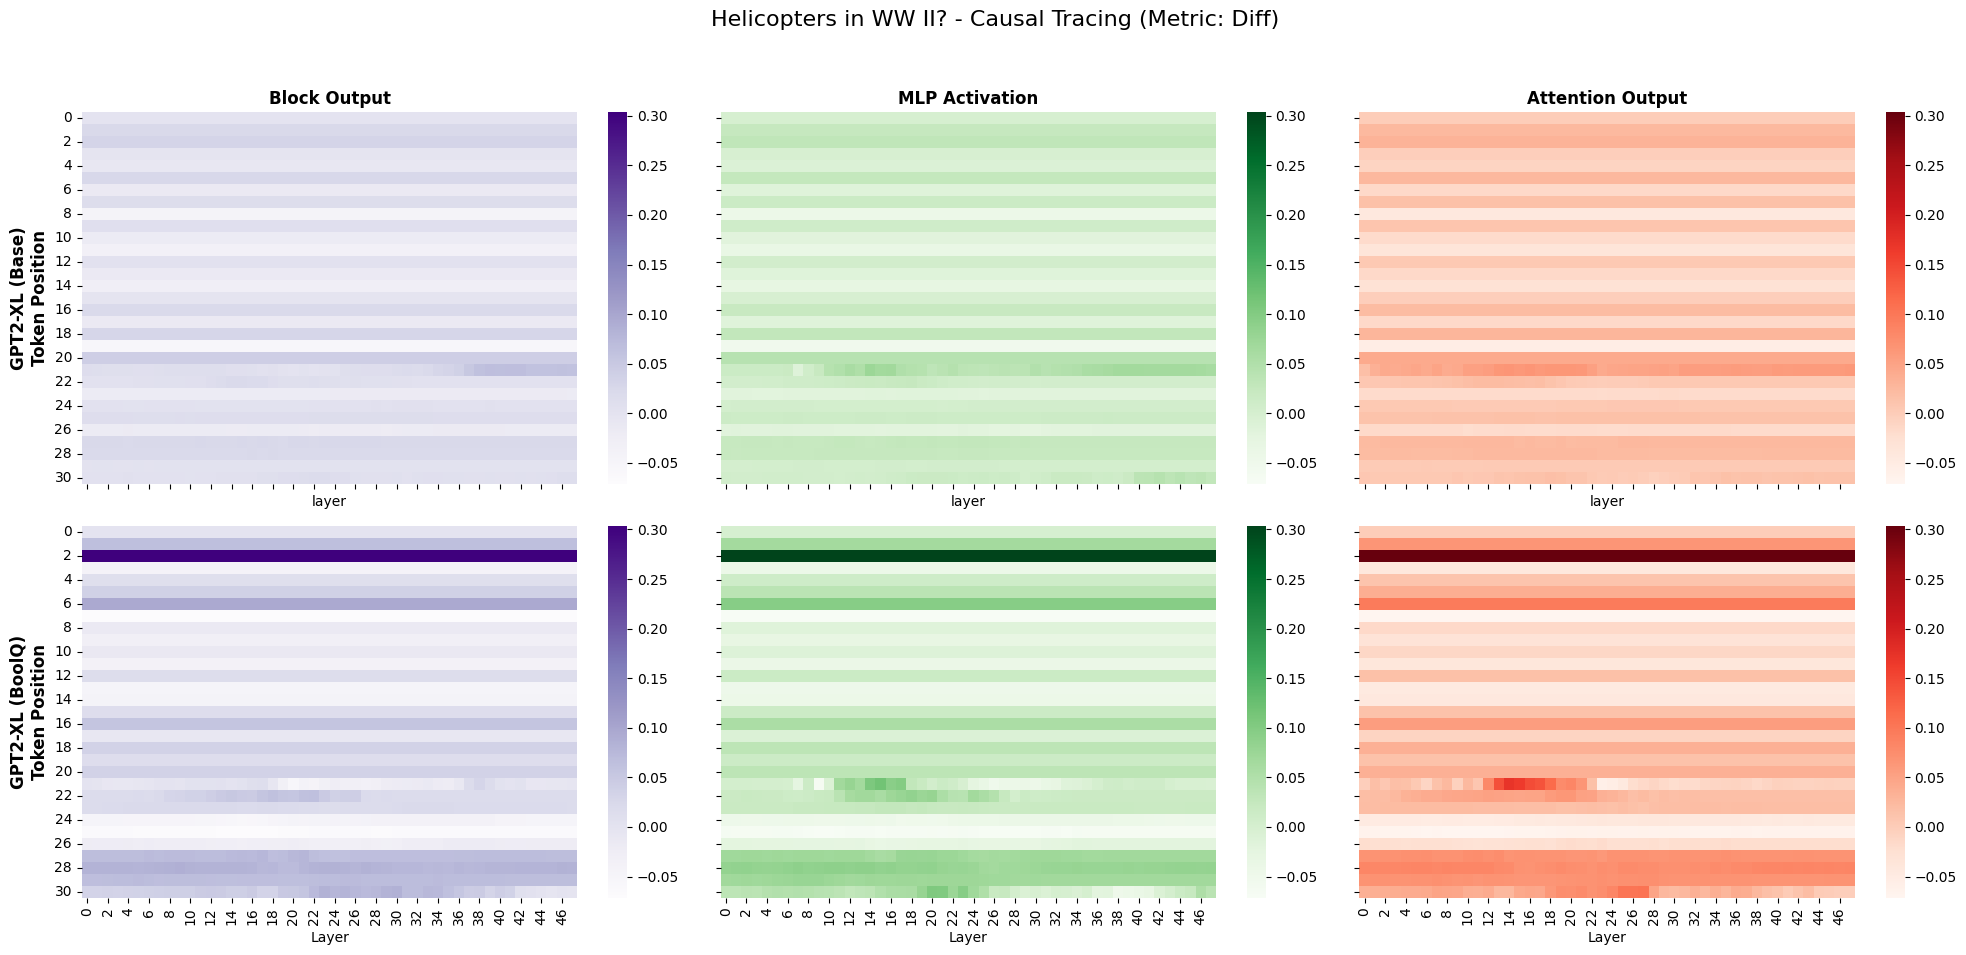

In [40]:
plot_2x3_comparison_streams(df_ex0_base, df_ex0_boolq, tokens_ex0_boolq, title_prefix="Helicopters in WW II?")

Calculating diff for answer ' No'. Baseline (corrupted) prob: 0.1019
Calculating diff for answer ' No'. Baseline (corrupted) prob: 0.1017


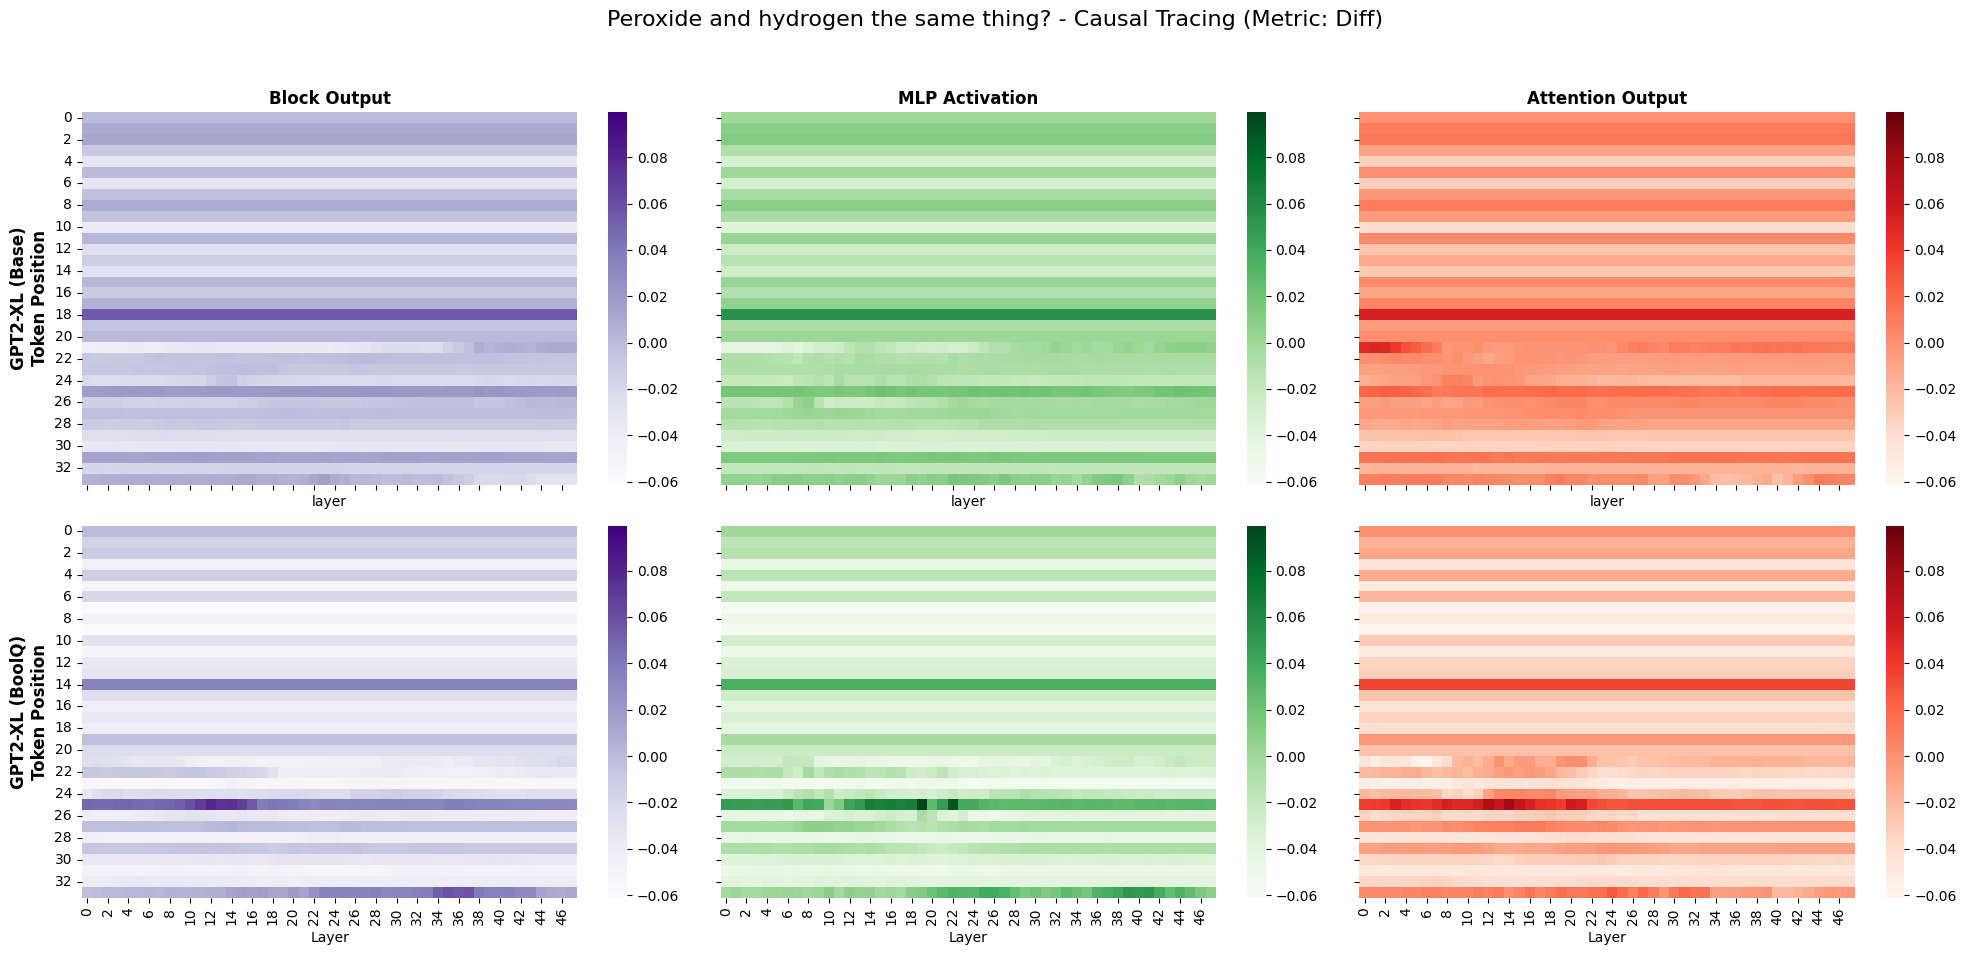

In [48]:
tokens_ex1_boolq = [t[0] for t in get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[1])]
df_ex1_base = pd.read_csv(f"outputs/yes_no_gpt2-xl_ex1.csv")
df_ex1_boolq = pd.read_csv(f"outputs/yes_no_boolq_gpt2-xl_ex1.csv")
df_ex1_base = recalculate_diff_for_plotting(
    df_ex1_base, gpt, tokenizer, prompts[1], [21,22,24,25,26], answers[1]
)
df_ex1_boolq = recalculate_diff_for_plotting(
    df_ex1_boolq, gpt2, tokenizer2, prompts[1], [21,22,24,25,26], answers[1]
)
plot_2x3_comparison_streams(df_ex1_base, df_ex1_boolq, tokens_ex1_boolq, title_prefix="Peroxide and hydrogen the same thing?")

Calculating diff for answer ' Yes'. Baseline (corrupted) prob: 0.1147
Calculating diff for answer ' Yes'. Baseline (corrupted) prob: 0.5873


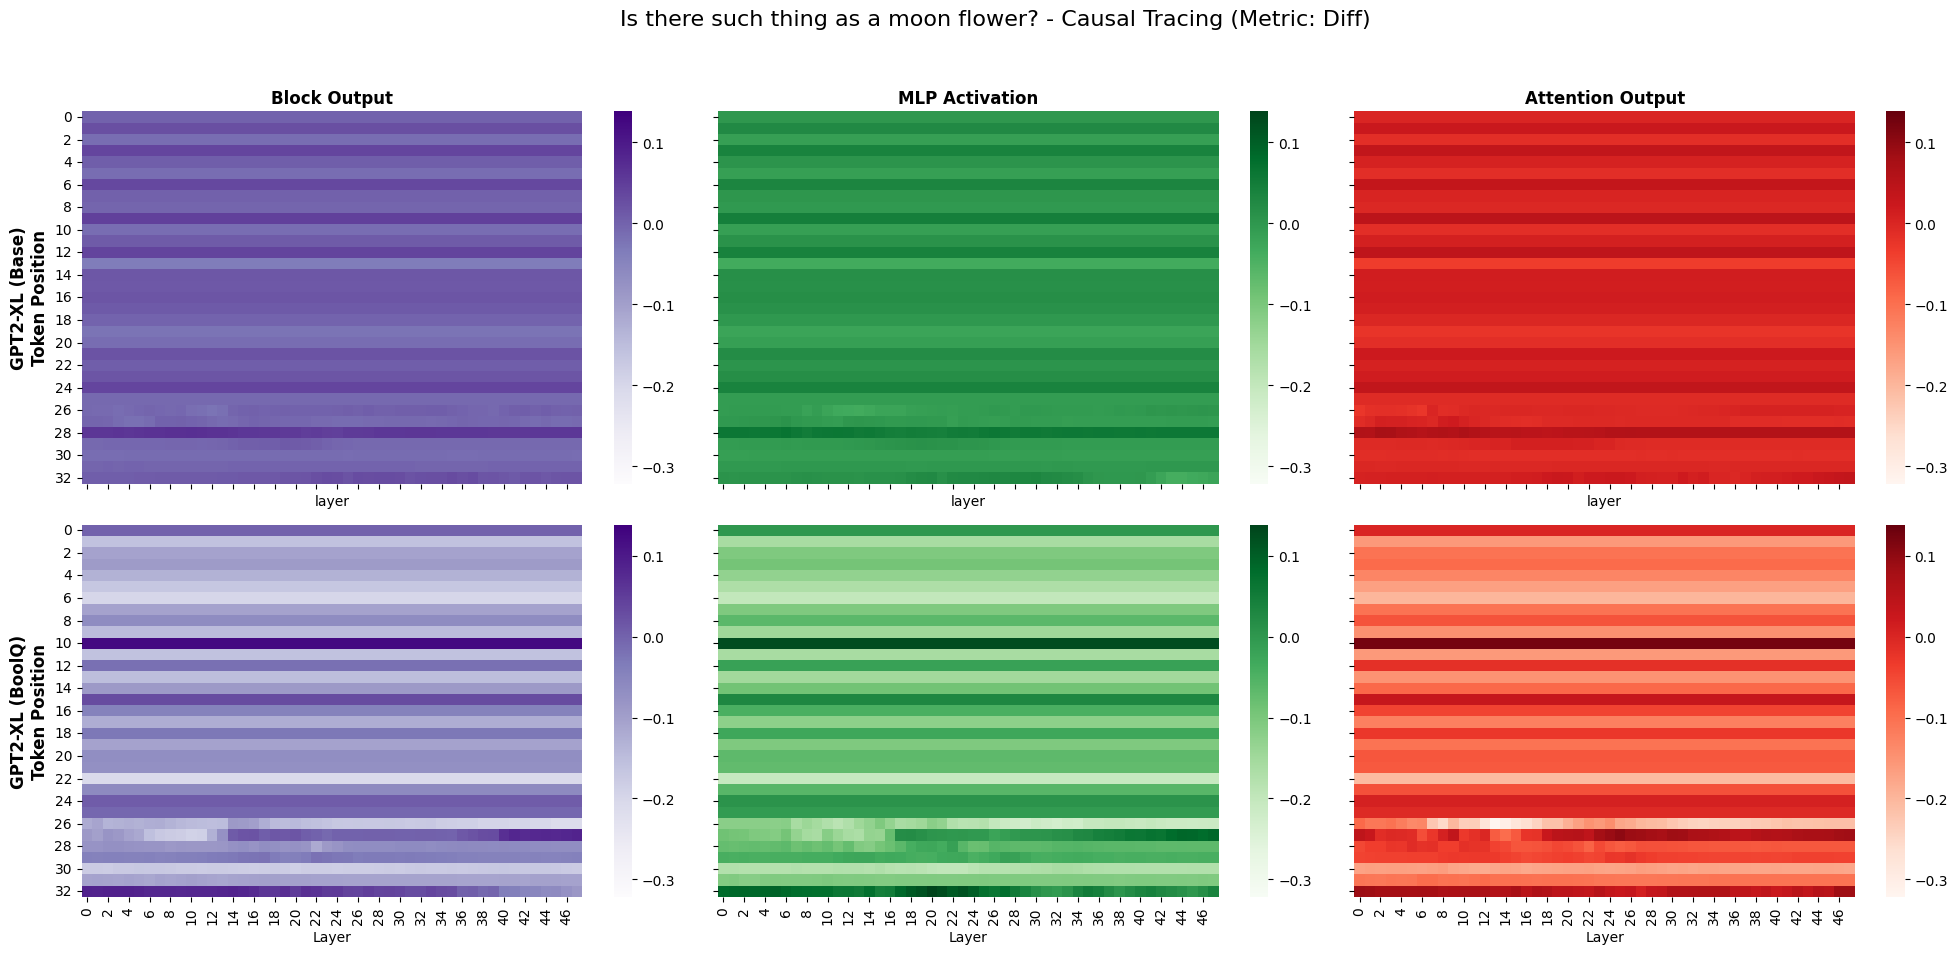

In [49]:
tokens_ex2_boolq = [t[0] for t in get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[2])]
df_ex2_base = pd.read_csv(f"outputs/yes_no_gpt2-xl_ex2.csv")
df_ex2_boolq = pd.read_csv(f"outputs/yes_no_boolq_gpt2-xl_ex2.csv")
df_ex2_base = recalculate_diff_for_plotting(
    df_ex2_base, gpt, tokenizer, prompts[2], [26,27,28], answers[2]
)
df_ex2_boolq = recalculate_diff_for_plotting(
    df_ex2_boolq, gpt2, tokenizer2, prompts[2], [26,27,28], answers[2]
)
plot_2x3_comparison_streams(df_ex2_base, df_ex2_boolq, tokens_ex2_boolq, title_prefix="Is there such thing as a moon flower?")

Calculating diff for answer ' Yes'. Baseline (corrupted) prob: 0.2050
Calculating diff for answer ' Yes'. Baseline (corrupted) prob: 0.2414


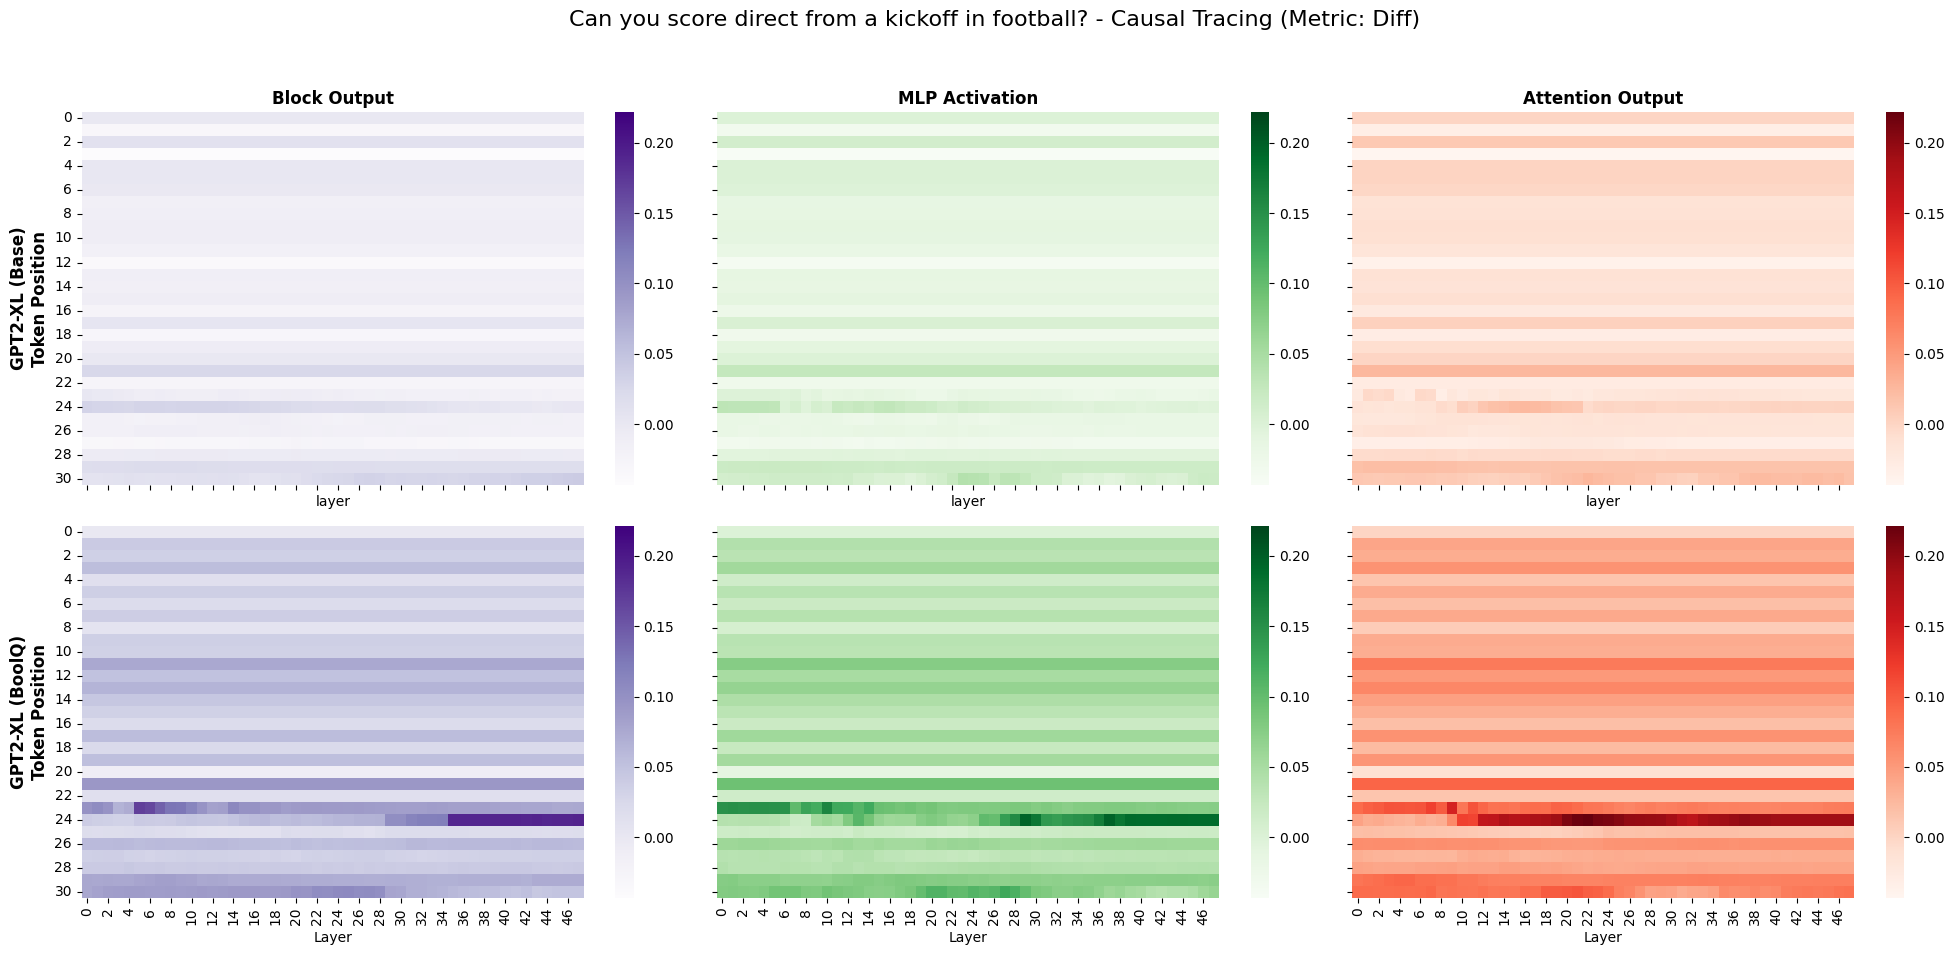

In [50]:
tokens_ex3_boolq = [t[0] for t in get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[3])]
df_ex3_base = pd.read_csv(f"outputs/yes_no_gpt2-xl_ex3.csv")
df_ex3_boolq = pd.read_csv(f"outputs/yes_no_boolq_gpt2-xl_ex3.csv")
df_ex3_base = recalculate_diff_for_plotting(
    df_ex3_base, gpt, tokenizer, prompts[3], [23,24], answers[3]
)
df_ex3_boolq = recalculate_diff_for_plotting(
    df_ex3_boolq, gpt2, tokenizer2, prompts[3], [23,24], answers[3]
)
plot_2x3_comparison_streams(df_ex3_base, df_ex3_boolq, tokens_ex3_boolq, title_prefix="Can you score direct from a kickoff in football?")

Calculating diff for answer ' No'. Baseline (corrupted) prob: 0.1123
Calculating diff for answer ' No'. Baseline (corrupted) prob: 0.0197


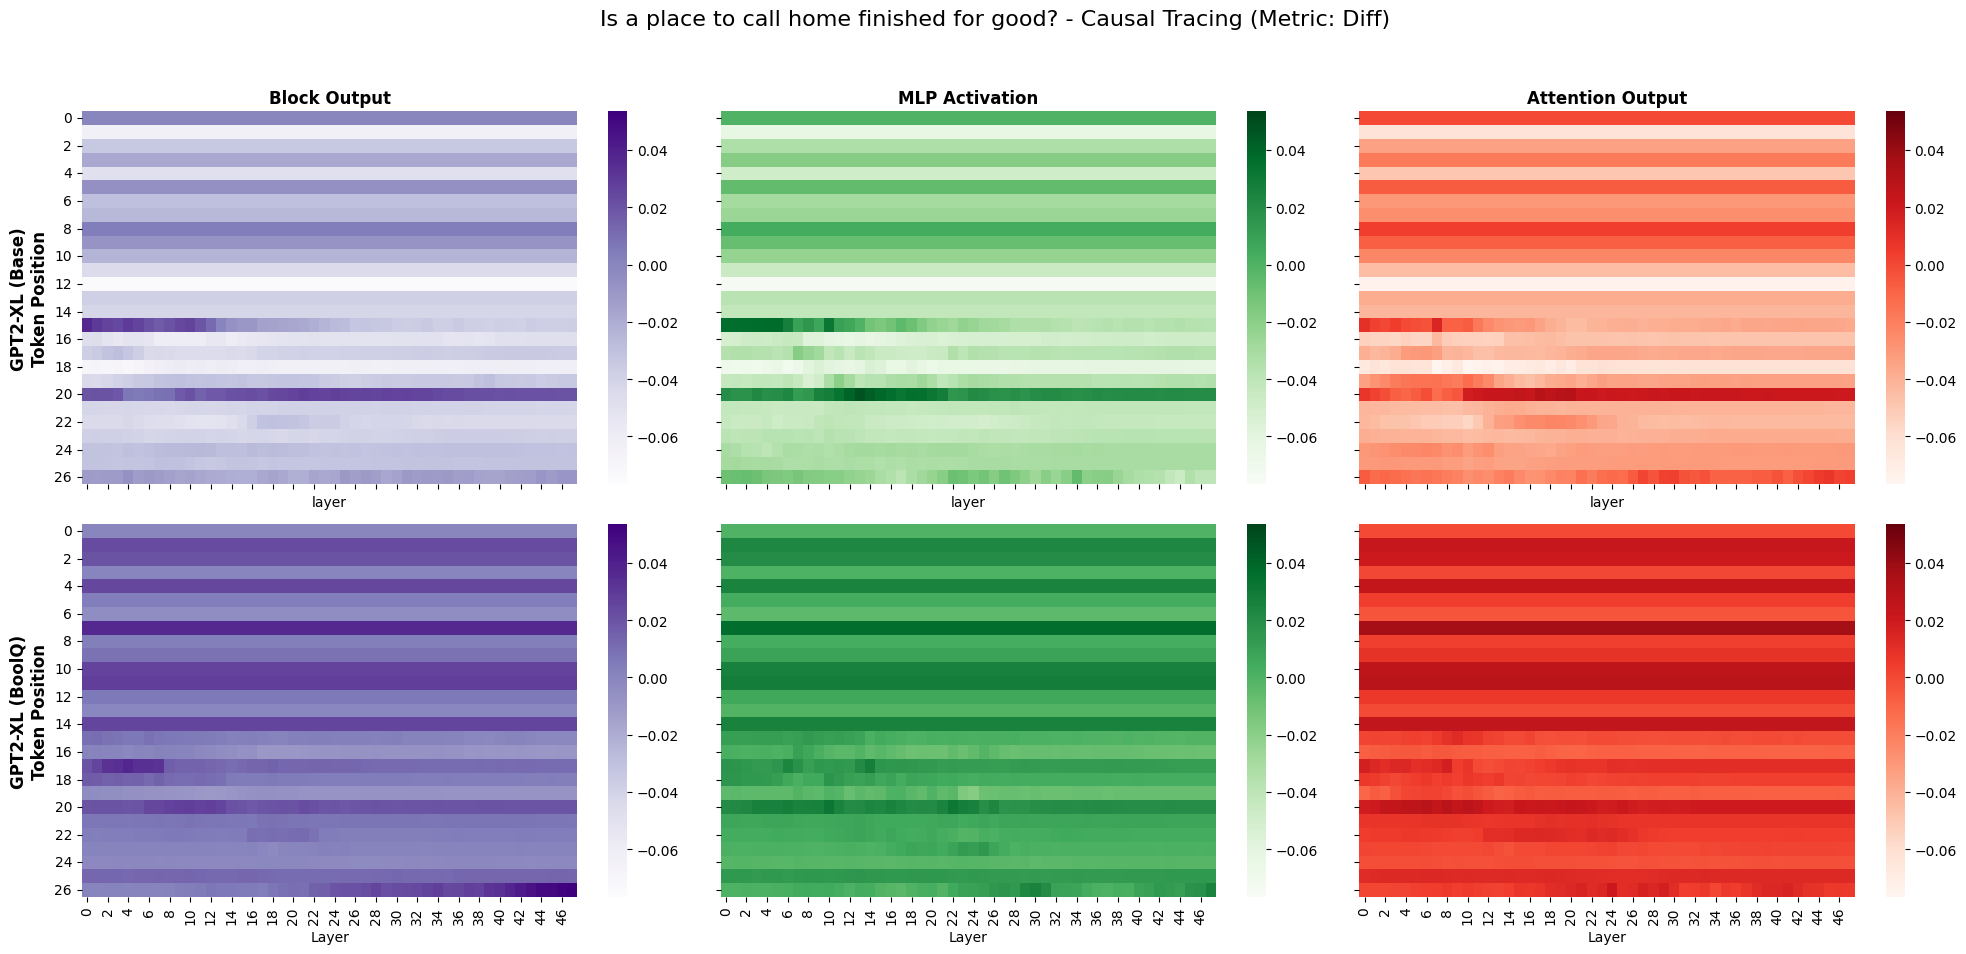

In [51]:
tokens_ex4_boolq = [t[0] for t in get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[4])]
df_ex4_base = pd.read_csv(f"outputs/yes_no_gpt2-xl_ex4.csv")
df_ex4_boolq = pd.read_csv(f"outputs/yes_no_boolq_gpt2-xl_ex4.csv")
df_ex4_base = recalculate_diff_for_plotting(
    df_ex4_base, gpt, tokenizer, prompts[4], [15,16,17,18,19], answers[4]
)
df_ex4_boolq = recalculate_diff_for_plotting(
    df_ex4_boolq, gpt2, tokenizer2, prompts[4], [15,16,17,18,19], answers[4]
)
plot_2x3_comparison_streams(df_ex4_base, df_ex4_boolq, tokens_ex4_boolq, title_prefix="Is a place to call home finished for good?")

Calculating diff for answer ' Yes'. Baseline (corrupted) prob: 0.0549
Calculating diff for answer ' Yes'. Baseline (corrupted) prob: 0.1256


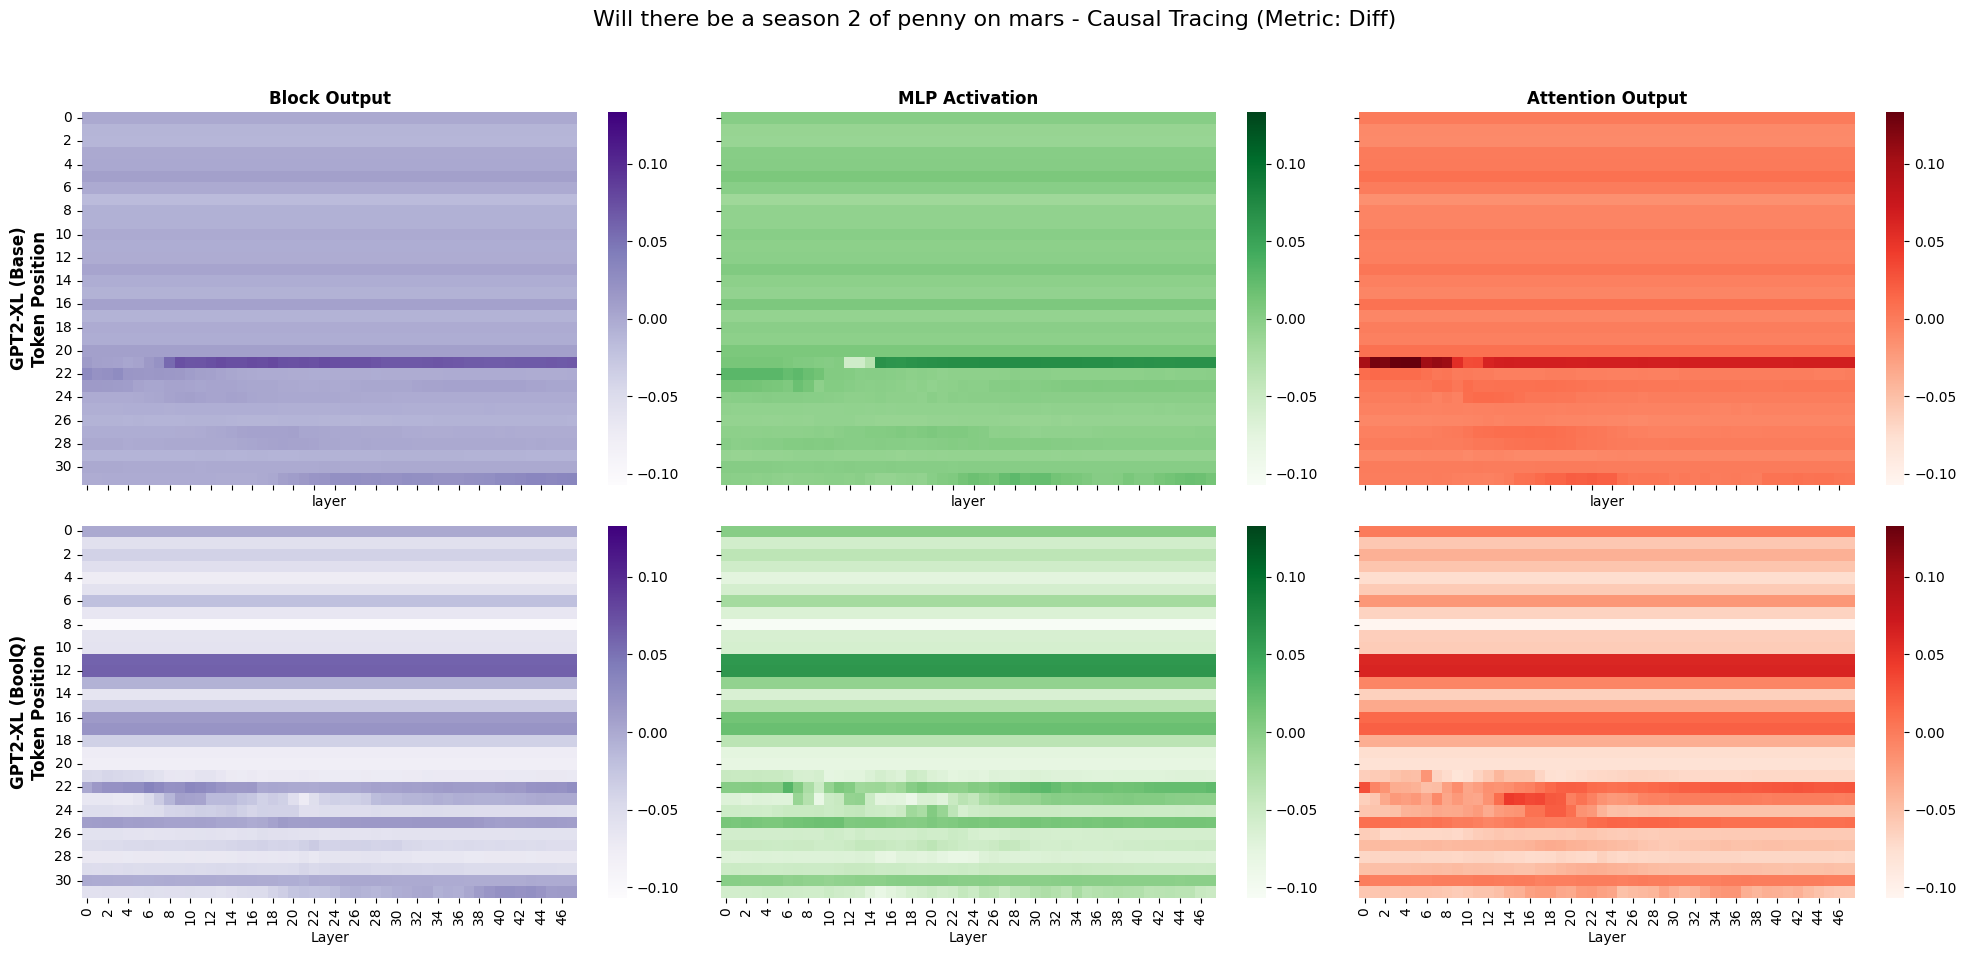

In [52]:
tokens_ex5_boolq = [
    t[0] for t in get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[5])
]
df_ex5_base = pd.read_csv(f"outputs/yes_no_gpt2-xl_ex5.csv")
df_ex5_boolq = pd.read_csv(f"outputs/yes_no_boolq_gpt2-xl_ex5.csv")
df_ex5_base = recalculate_diff_for_plotting(
    df_ex5_base, gpt, tokenizer, prompts[5], [21, 22, 23], answers[5]
)
df_ex5_boolq = recalculate_diff_for_plotting(
    df_ex5_boolq, gpt2, tokenizer2, prompts[5], [21, 22, 23], answers[5]
)
plot_2x3_comparison_streams(df_ex5_base, df_ex5_boolq, tokens_ex5_boolq, title_prefix="Will there be a season 2 of penny on mars")

Calculating diff for answer ' Yes'. Baseline (corrupted) prob: 0.0621
Calculating diff for answer ' Yes'. Baseline (corrupted) prob: 0.0386


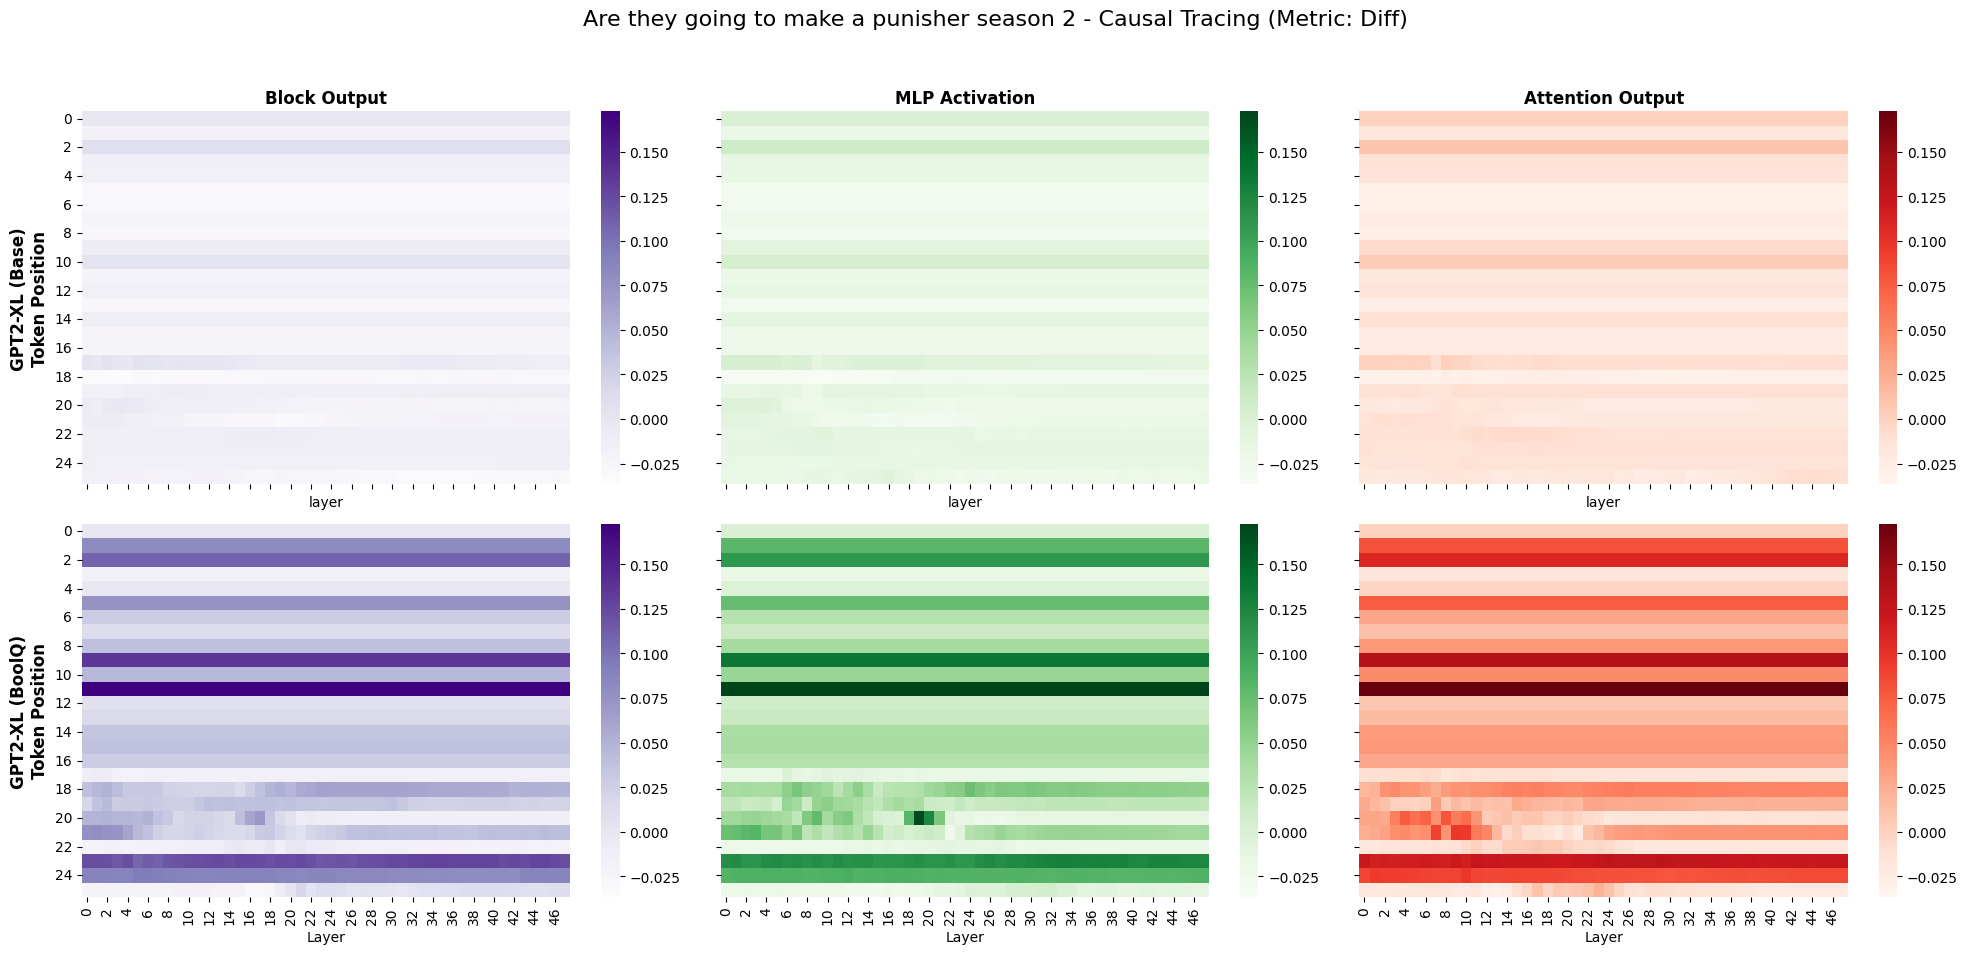

In [53]:
tokens_ex6_boolq = [
    t[0] for t in get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[6])
]
df_ex6_base = pd.read_csv(f"outputs/yes_no_gpt2-xl_ex6.csv")
df_ex6_boolq = pd.read_csv(f"outputs/yes_no_boolq_gpt2-xl_ex6.csv")
df_ex6_base = recalculate_diff_for_plotting(
    df_ex6_base, gpt, tokenizer, prompts[6], [17, 18, 19, 20, 21], answers[6]
)
df_ex6_boolq = recalculate_diff_for_plotting(
    df_ex6_boolq, gpt2, tokenizer2, prompts[6], [17, 18, 19, 20, 21], answers[6]
)
plot_2x3_comparison_streams(df_ex6_base, df_ex6_boolq, tokens_ex6_boolq, title_prefix="Are they going to make a punisher season 2")

Calculating diff for answer ' Yes'. Baseline (corrupted) prob: 0.0947
Calculating diff for answer ' Yes'. Baseline (corrupted) prob: 0.0576


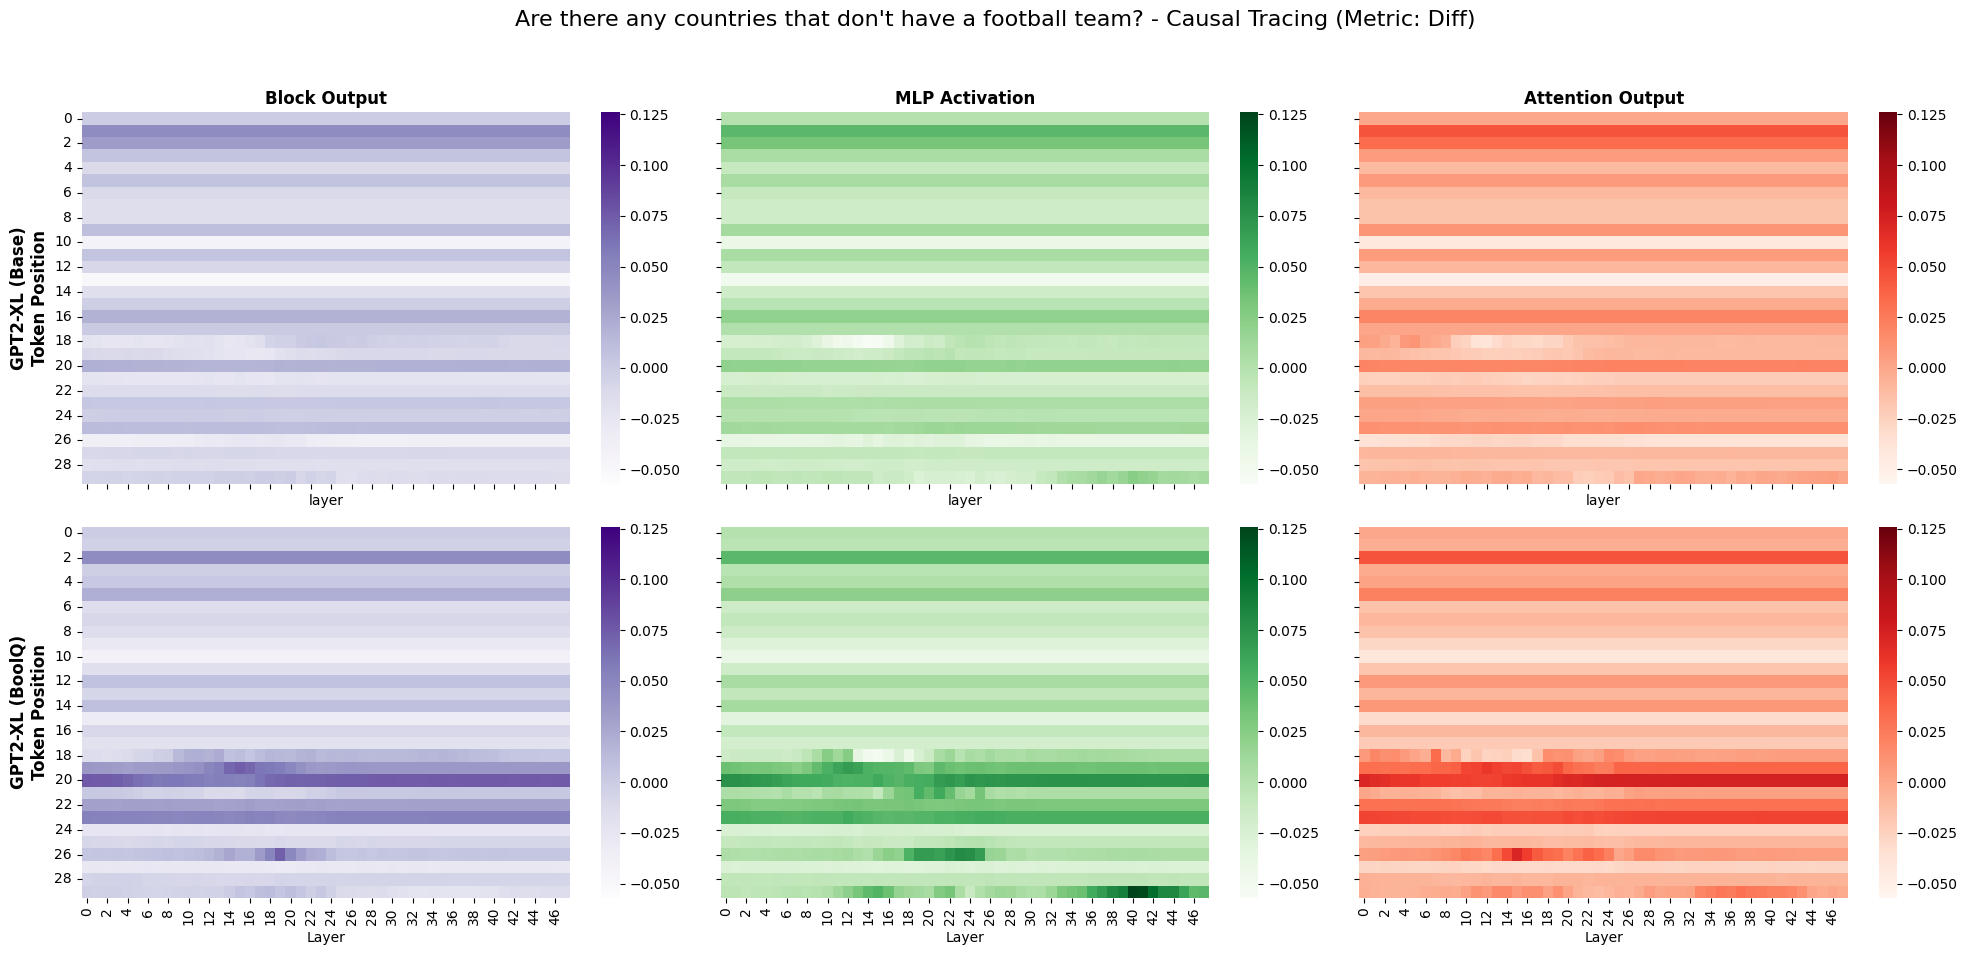

In [54]:
tokens_ex7_boolq = [
    t[0] for t in get_the_tokens_and_ids(tokenizer=tokenizer, base_text=prompts[7])
]
df_ex7_base = pd.read_csv(f"outputs/yes_no_gpt2-xl_ex7.csv")
df_ex7_boolq = pd.read_csv(f"outputs/yes_no_boolq_gpt2-xl_ex7.csv")
df_ex7_base = recalculate_diff_for_plotting(
    df_ex7_base, gpt, tokenizer, prompts[7], [18], answers[7]
)
df_ex7_boolq = recalculate_diff_for_plotting(
    df_ex7_boolq, gpt2, tokenizer2, prompts[7], [18], answers[7]
)
plot_2x3_comparison_streams(df_ex7_base, df_ex7_boolq, tokens_ex7_boolq, title_prefix="Are there any countries that don't have a football team?")